In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import yaml
import collections
from tqdm import tqdm

# Load in all predictions

In [3]:
classnames = ['biotic', 'anthrop']

In [4]:
predictions = {}

for classname in classnames:
    
    base_savedir = '/media/michael/SeagateData/alison_data/predictions_%s/' % classname
    predictions[classname] = {}

    for root, dirnames, filenames in tqdm(os.walk(base_savedir)):

        for fname in filenames:

            if fname.endswith('.npy'):
                P = np.load(root + '/' + fname)[:, 1]

                if 'E29' in root:
                    sitename = 'E29RR'
                else:
                    sitename = root.replace('/SM2+', '').split('/')[-1]
                
                predictions[classname][fname.split('.npy')[0]] = (sitename, P)

151it [00:46,  1.78it/s]
151it [00:46,  2.03it/s]


# Filter by site name

In [5]:
summaries = collections.defaultdict(dict)
site_filtered = {}

to_exclude = ['Card slot', 'copy', 'Sliced', '250515-010615', 'NOISE']


for classname in classnames:
    
    print "Class: ", classname
    print "Found %d predictions" % len(predictions[classname])
    
    site_filtered[classname] = collections.defaultdict(dict)

    for fname, (sitename, P) in predictions[classname].iteritems():

        if all(xx not in sitename for xx in to_exclude):
            site_filtered[classname][sitename][fname] = P

    print "Found %d unique sites" % len(site_filtered[classname])

    # Summarising per-site
    site_summaries = {}
    for site, preds in site_filtered[classname].iteritems():
        site_summaries[site] = np.nanmean(np.hstack(preds.values()).astype(float))
    
    # Sorting and printing
    site_summaries_l = site_summaries.items()
    site_summaries_l = sorted(site_summaries_l, key=lambda x:x[1])

    for site, pred in site_summaries_l:

        summaries[classname][site] = pred

Class:  biotic
Found 32004 predictions
Found 63 unique sites
Class:  anthrop
Found 32004 predictions
Found 63 unique sites


In [6]:
print site_filtered.keys()

['biotic', 'anthrop']


# Writing the summaries to disk

In [10]:
import pandas as pd
df = pd.DataFrame(summaries)
df.to_csv('/home/michael/Dropbox/engage/FairbrassFirmanetal_/data/predictions/massive_dataset/per_site_summaries.csv')

# Writing the raw data to disk

In [11]:
savedir = '/home/michael/Dropbox/engage/FairbrassFirmanetal_/data/predictions/massive_dataset/raw_predictions/'

for site in site_filtered['biotic']:
    
    dic = {'biotic': np.hstack(site_filtered['biotic'][site]),
     'anthrop': np.hstack(site_filtered['anthrop'][site])}

    df = pd.DataFrame(dic)

    savepath = savedir + site + '.csv'
    df.to_csv(savepath, index=False, float_format='%0.5f')       

# Doing per-site graphs

In [8]:
import datetime
sys.path.append('../../evaluation/two_sites_comparison/')
from sunrise import sun

# london GPS location
s = sun(lat=51,long=0.1)


def fname_to_time(fname, sitename):
    """From a filename, extract the time"""
    if sitename == 'RM143YB':
        string = fname.split('_')[-2][:4]
        hours = int(string[:2])
        minutes = int(np.floor(int(string[2:]) / 30.0) * 30)
        return "%02d%02d" % (hours, minutes)
    else:
        return fname.split('_')[-1][:4]


def datetime_to_decimal(dt):
    """Convert datetime object to time as hour in decmals"""
    return float(dt.hour) + dt.minute / 60.0


def get_times_and_averages(sitename, classname):
    results = collections.defaultdict(list)
    for fname, pred in site_filtered[classname][sitename].iteritems():
        time = fname_to_time(fname, sitename)
        results[time].append(pred)
        
    results = dict(results)

    averages = []
    times = []
    
    # loop over each time and get the keys and summaries
    for hour in range(24):
        for half in [0, 1]:
            key = '%02d%02d' % (hour, half*30)
            try:
                averages.append(np.nanmean(np.hstack(results[key])))
            except:
#                 print "Failure - ", sitename, key
#                 print np.nanmean(np.hstack(results[key]))
                averages.append(averages[-1])

            times.append(hour + half * 0.5 + 0.25)
    return times, averages


lw = 10 # line width

def plot_results(sitename, classname, style_level=2):
    """For a filename base, plot all theresults summaries"""
    
    
    sun_colour = np.array([117, 112, 179]) / 255.0
    biotic_col = np.array([27, 158, 119]) / 255.0
    anthrop_col = np.array([217, 95, 2]) / 255.0

    times, averages = get_times_and_averages(sitename, classname)

    # Plotting activity levels
    col = biotic_col if  classname == 'biotic' else anthrop_col
    plt.plot(times, averages, linewidth=lw, color=col)#, label=mapper[classname])
    
    if style_level >= 2:
        plt.xlabel('Hour of day', fontsize=16)
        plt.ylabel('Level of activity', fontsize=16)
        plt.yticks([0, 1.0], fontsize=14)    
        plt.xticks([0, 6, 12, 18, 24], ['00:00', '06:00', '12:00', '18:00', '24:00'], fontsize=14)
    else:
        plt.xticks([])
        plt.yticks([])
        
    plt.xlim(0, 24)
    plt.ylim(0, 1)
    
    for axis in ['bottom','left']:
        plt.gca().spines[axis].set_linewidth(lw)

    # Plotting sunset/sunrise times
    these_fnames = site_filtered[classname][sitename].keys()
    
    if sitename == 'RM143YB':
        datestrs = [xx.split('_')[2] for xx in these_fnames]
    else:
        datestrs = [xx.split('_')[1] for xx in these_fnames]
    
    sunrises = []
    sunsets = []
    
    for datestr in datestrs:
        when = datetime.datetime.strptime(datestr, '%Y%m%d')
        sunrises.append(datetime_to_decimal(s.sunrise(when=when)))
        sunsets.append(datetime_to_decimal(s.sunset(when=when)))
            
    sr = np.mean(sunrises)
    ss = np.mean(sunsets)

    plt.plot([sr, sr], [0.075, 1], '--', color=sun_colour, linewidth=lw)
    #plt.text(sr - 1.3, 1.01, 'Sunrise', fontsize=16, color=sun_colour)
    if style_level >= 1:
        plt.text(sr - 1.3, .015, 'Sunrise', fontsize=16, color=sun_colour)
    
    plt.plot([ss, ss], [0.075, 1], '--', color=sun_colour, linewidth=lw)
    if style_level >= 1:
        plt.text(ss - 1.3, .015, 'Sunset', fontsize=16, color=sun_colour)
    return times, averages

    
import seaborn as sns
sns.set_style('white')

def plot_site(sitename, style_level=2):
    plt.figure(figsize=(10, 4.5))
    plot_results(sitename, 'anthrop', style_level)
    plot_results(sitename, 'biotic', style_level)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

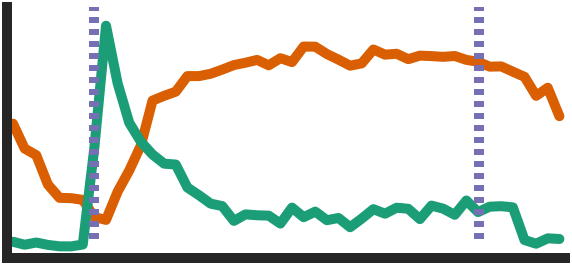

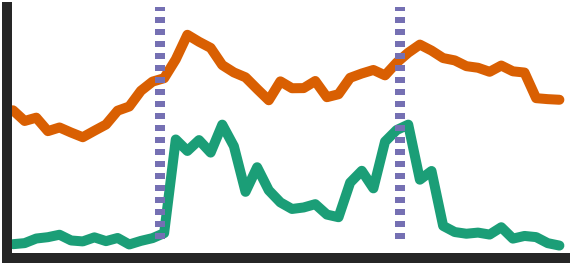

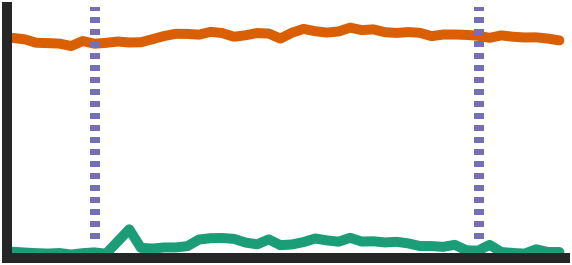

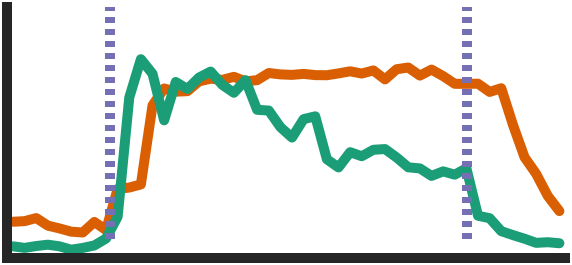

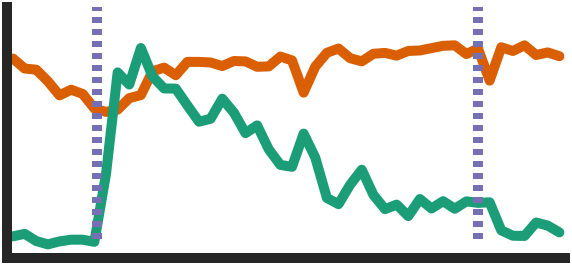

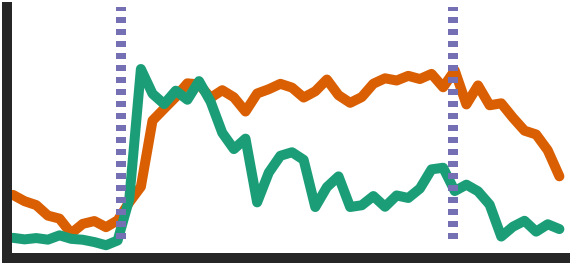

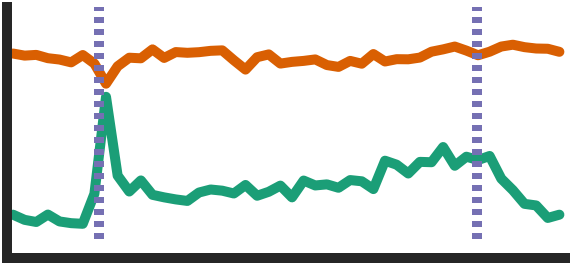

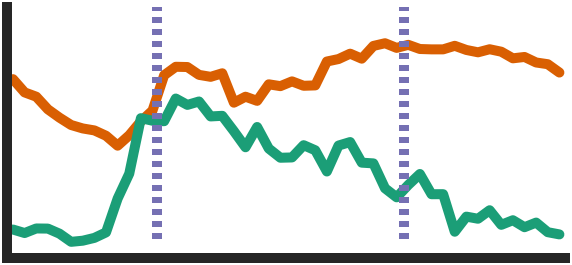

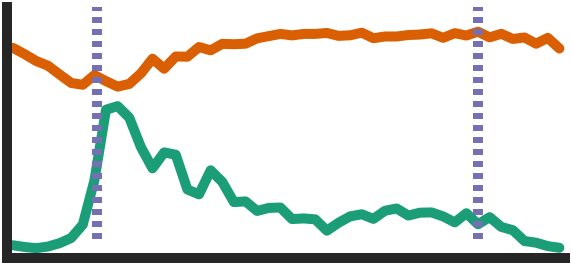

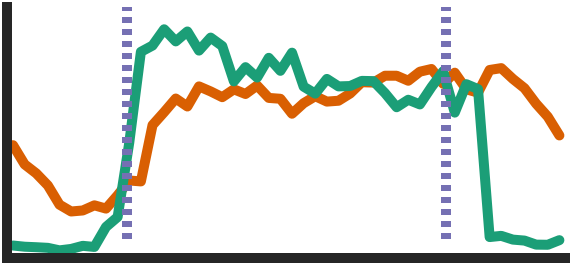

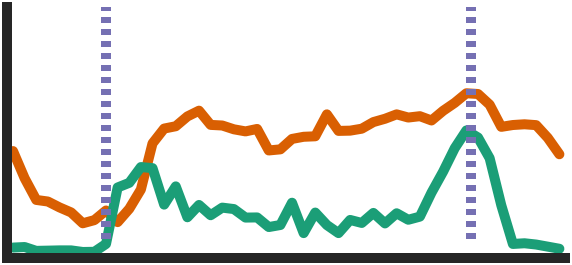

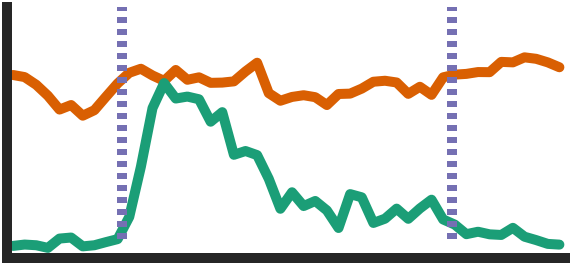

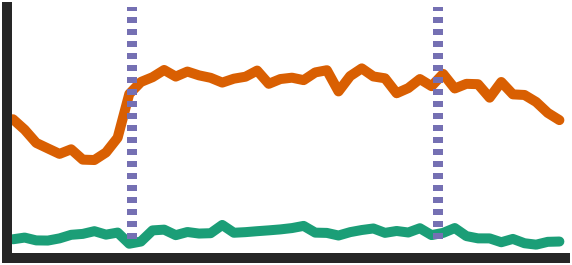

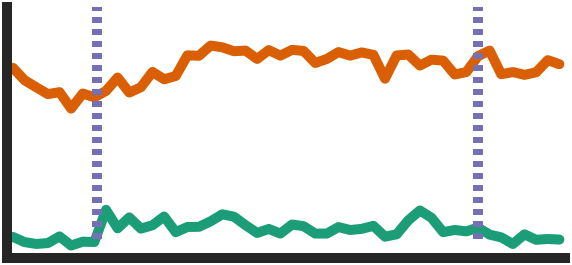

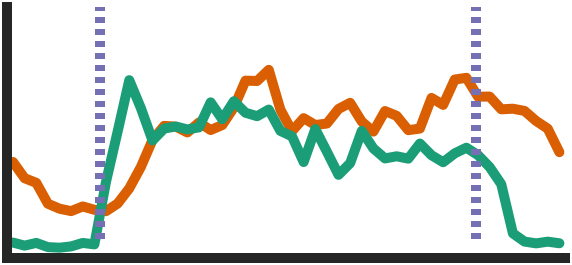

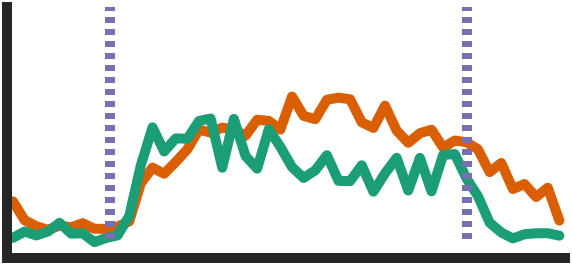

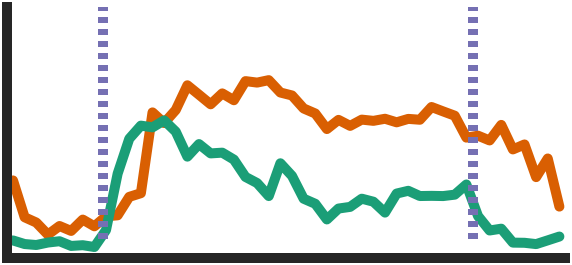

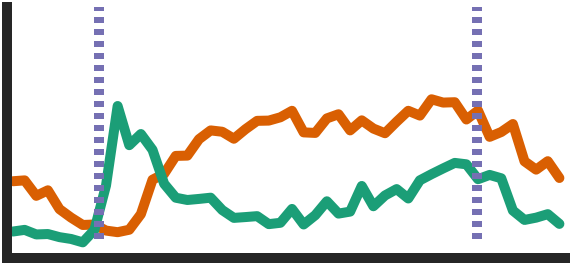

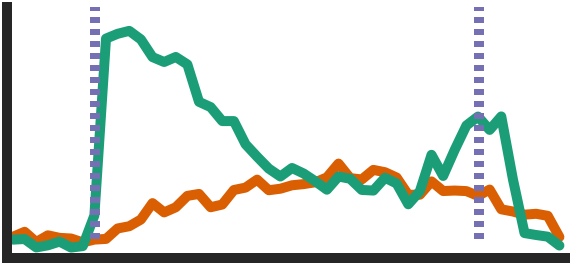

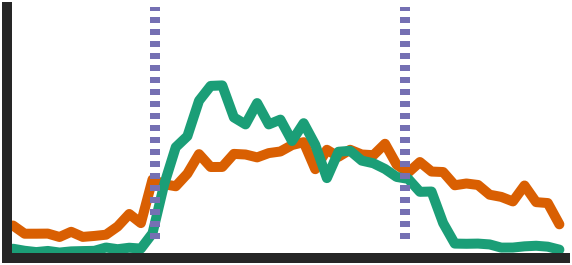

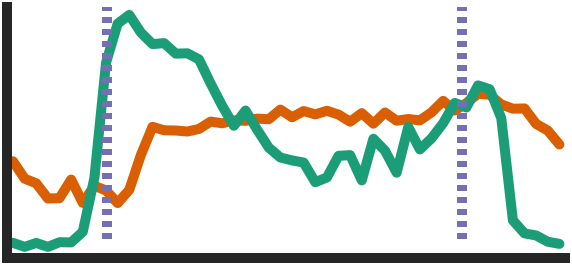

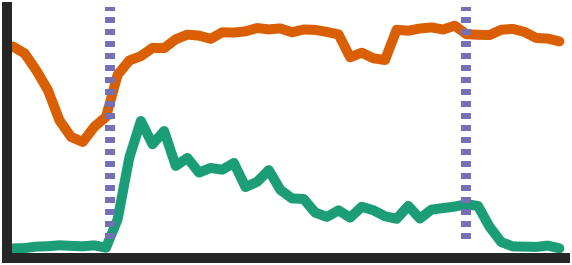

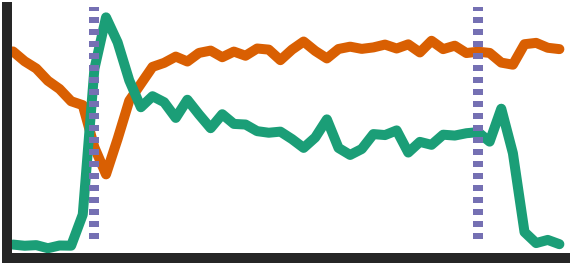

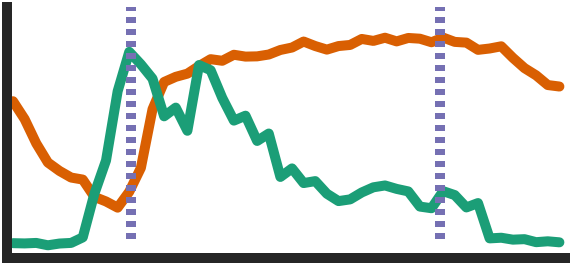

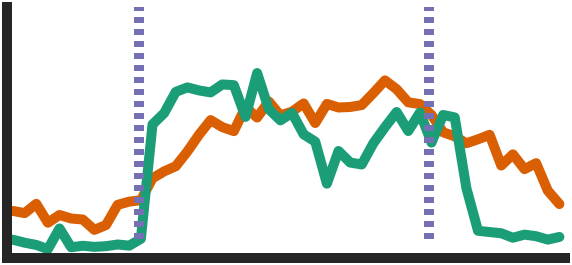

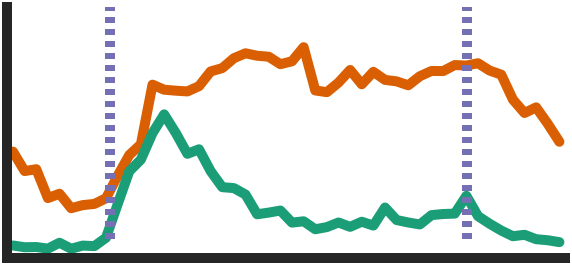

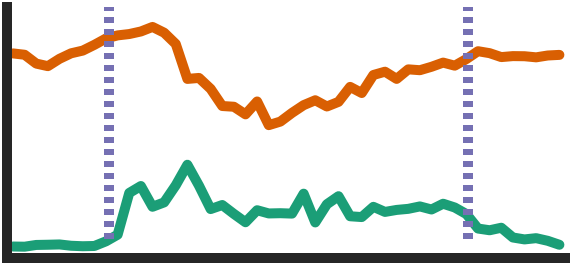

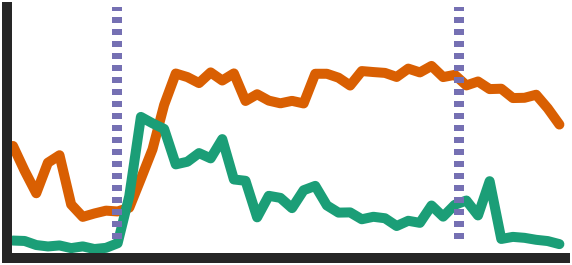

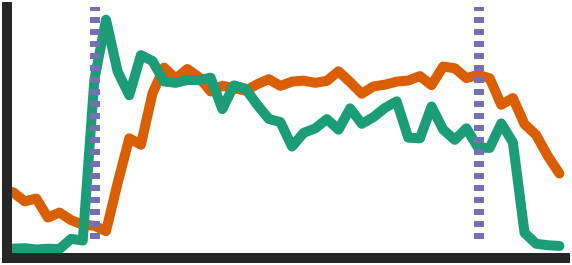

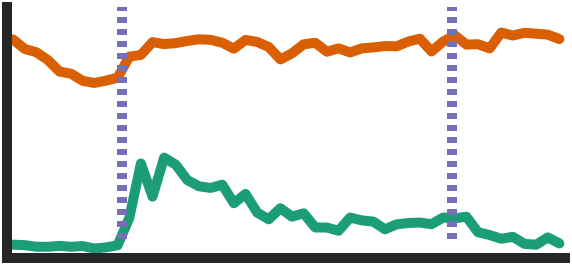

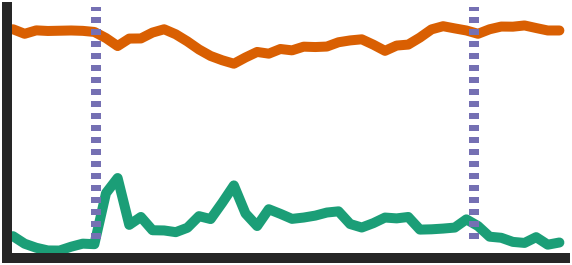

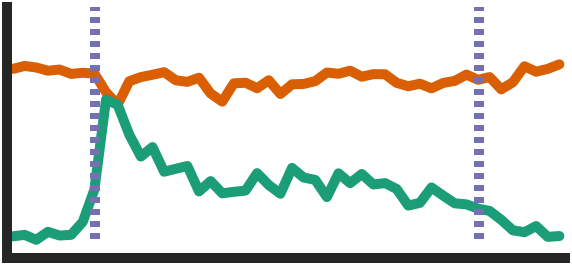

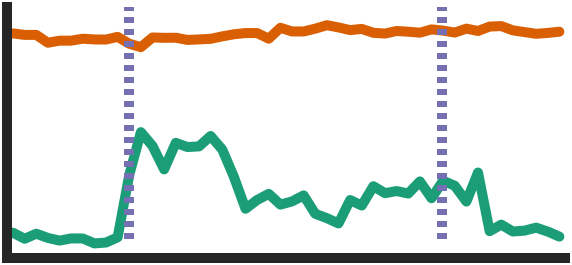

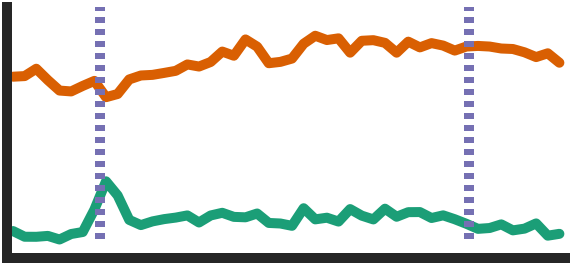

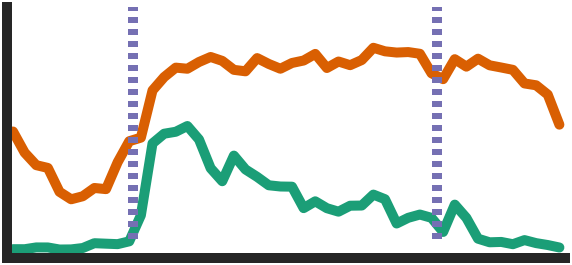

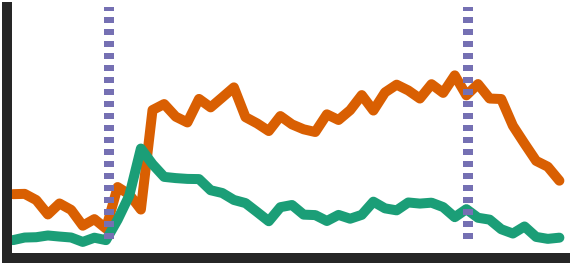

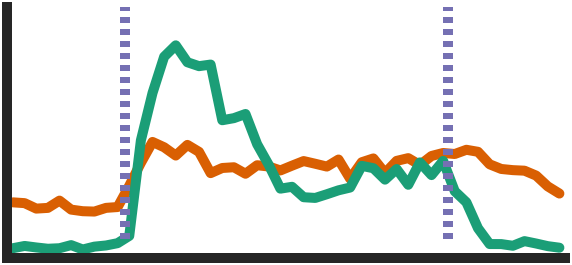

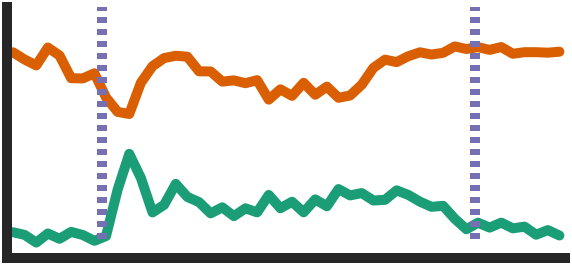

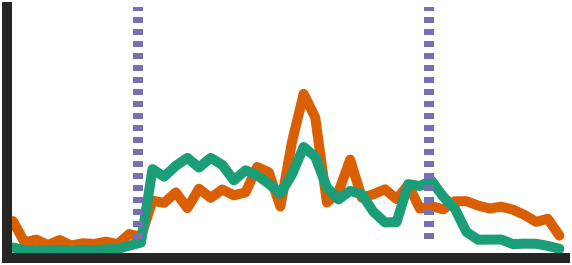

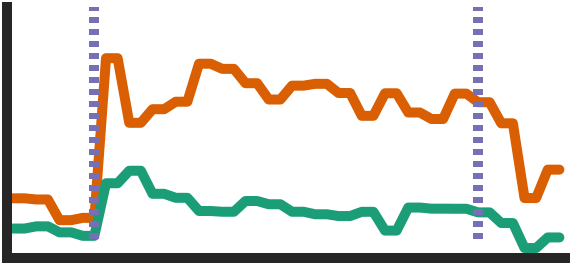

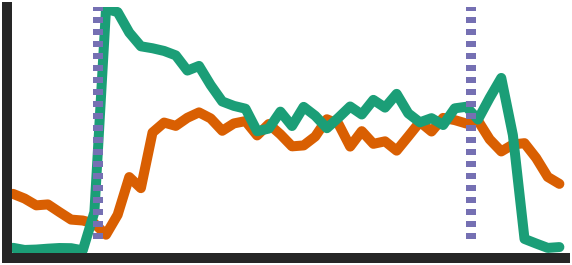

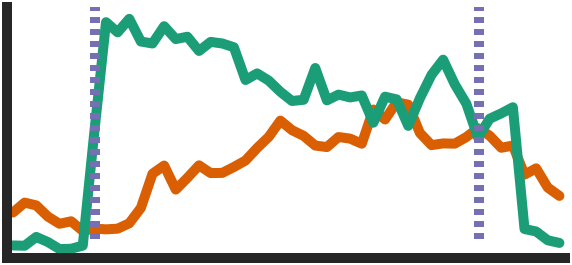

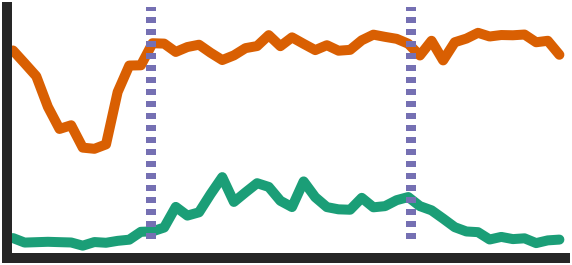

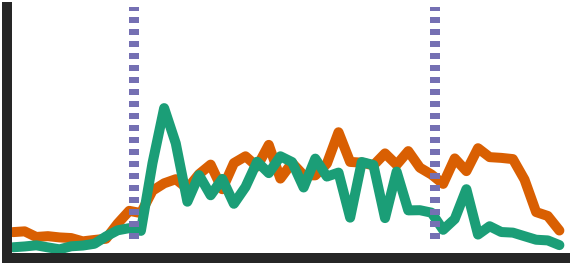

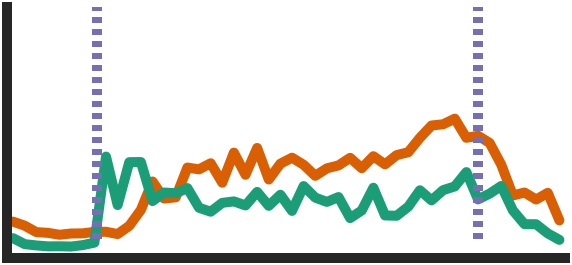

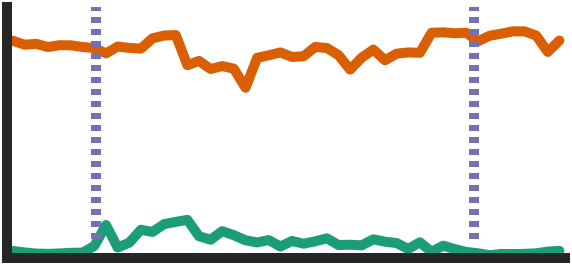

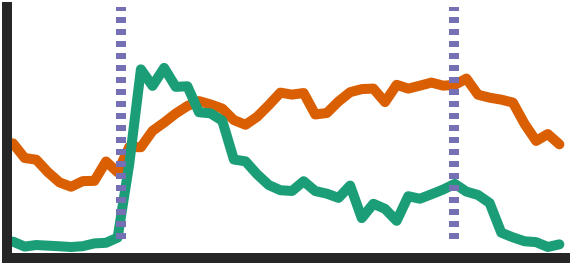

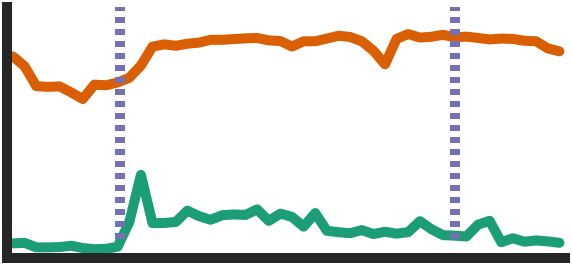

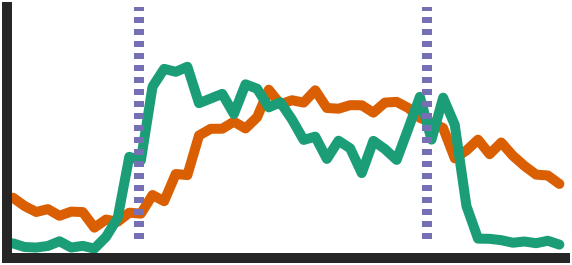

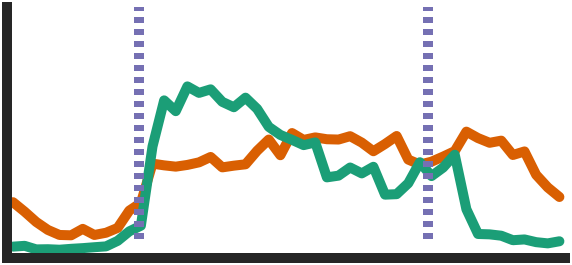

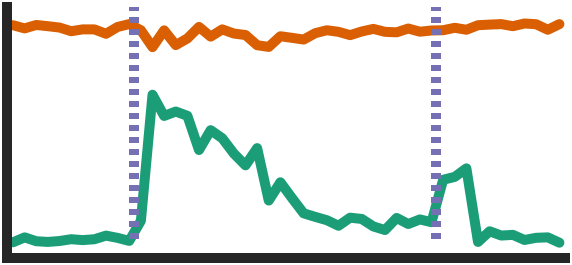

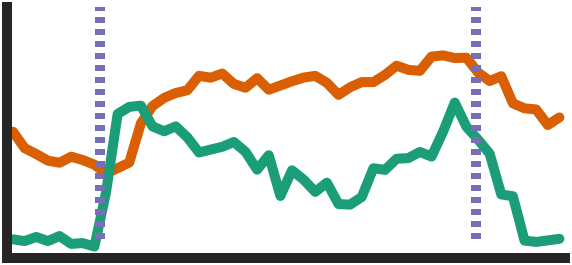

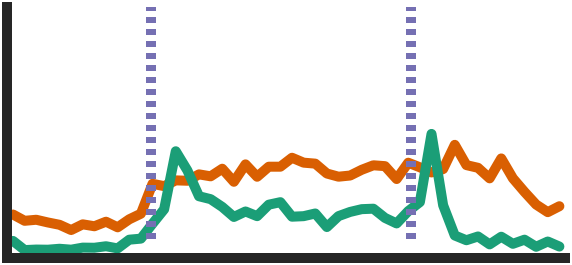

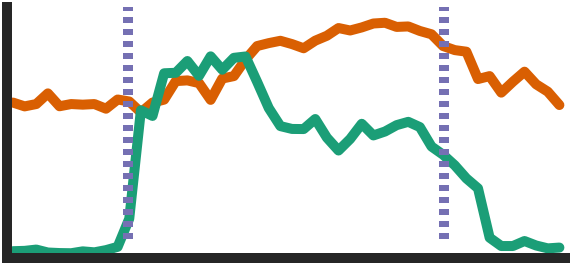

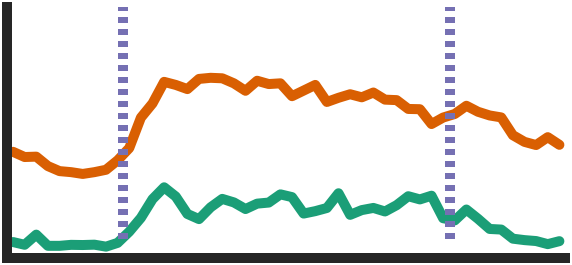

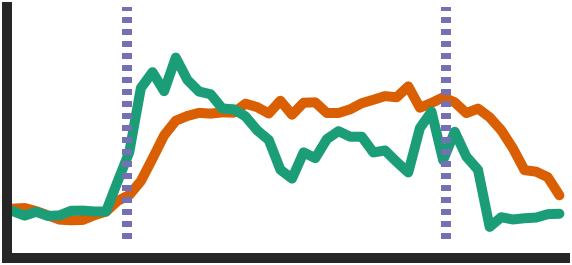

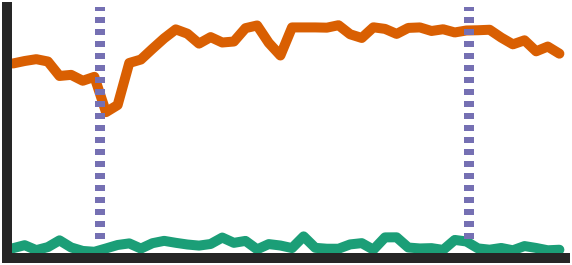

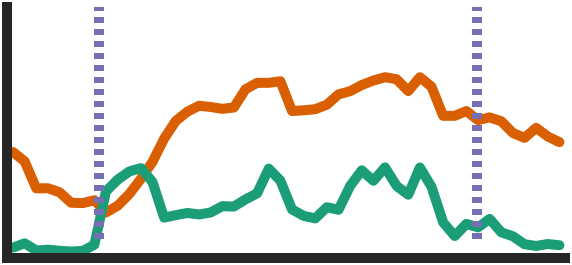

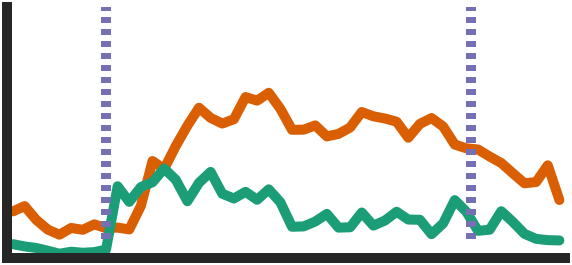

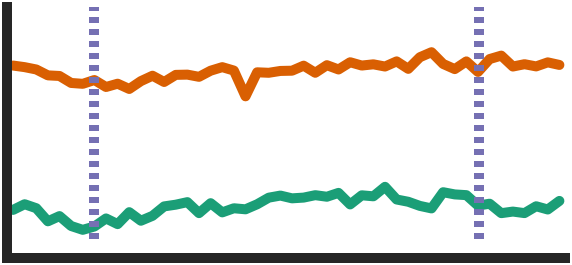

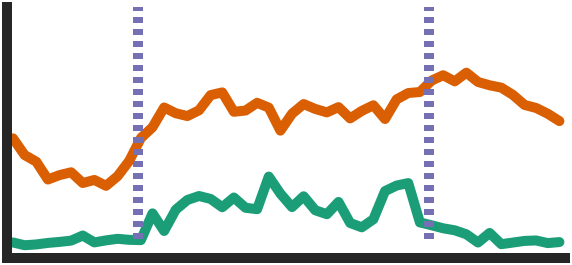

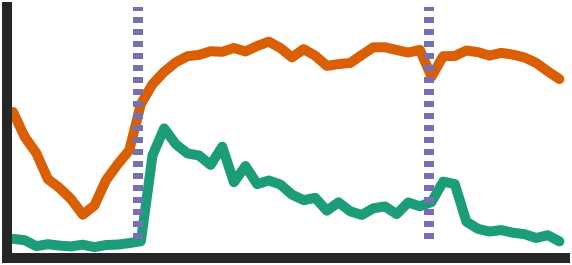

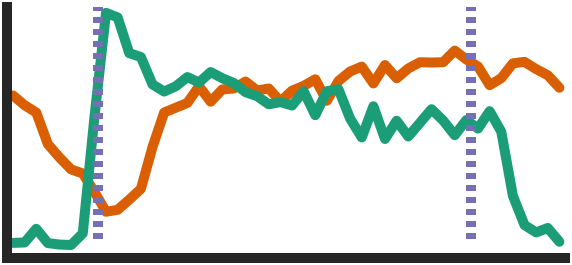

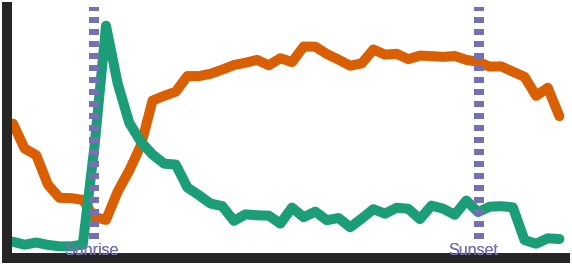

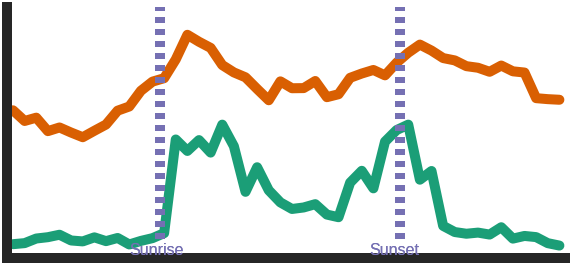

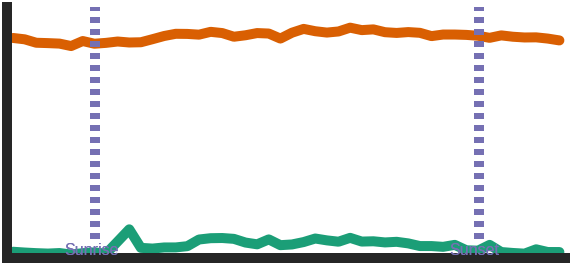

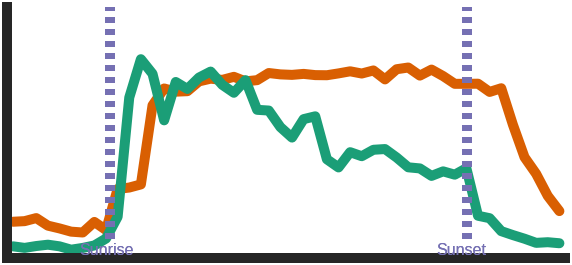

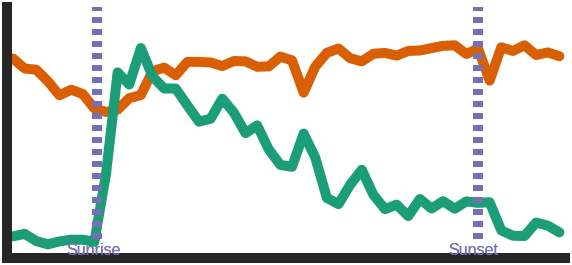

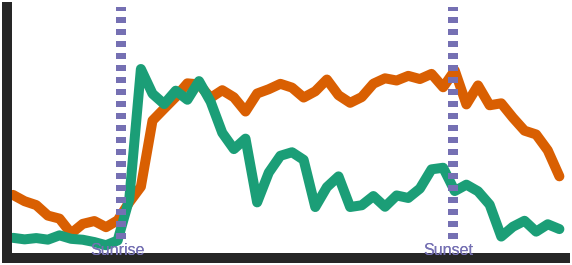

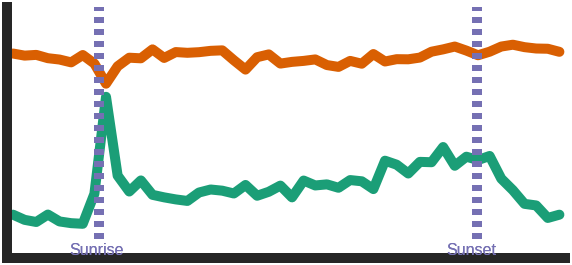

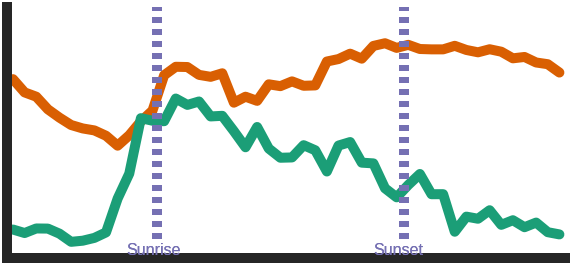

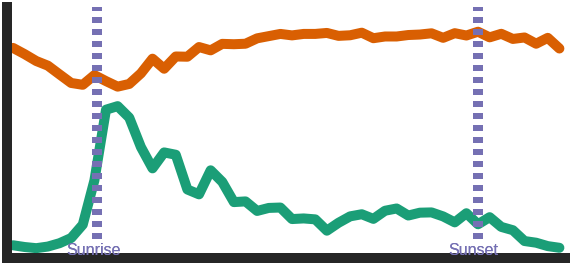

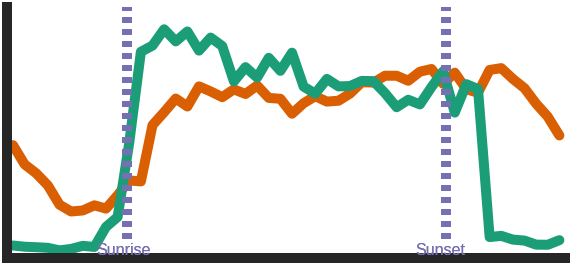

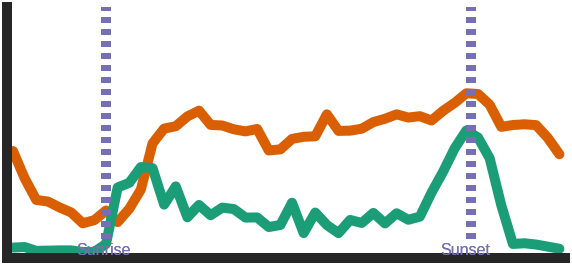

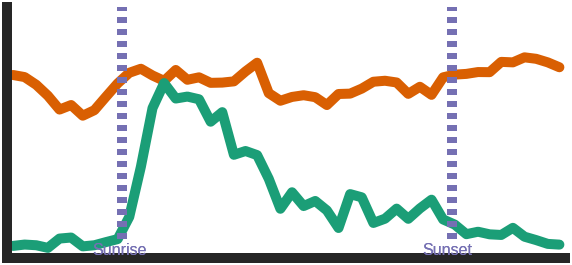

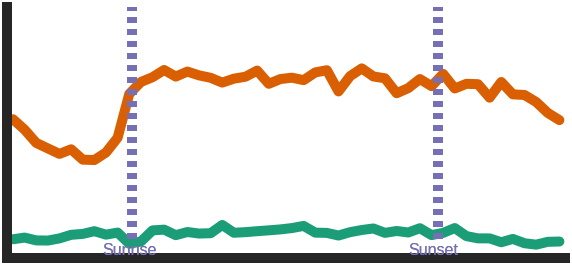

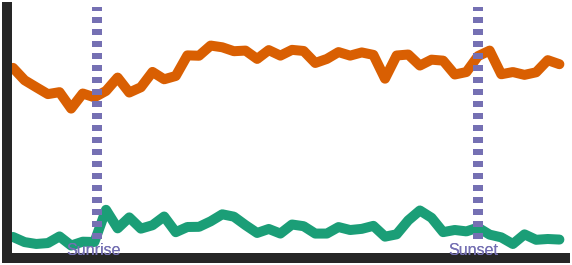

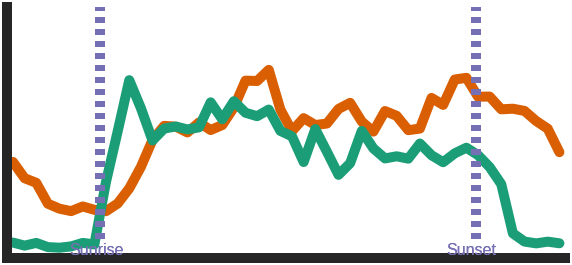

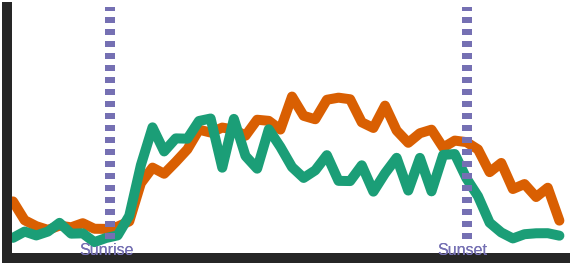

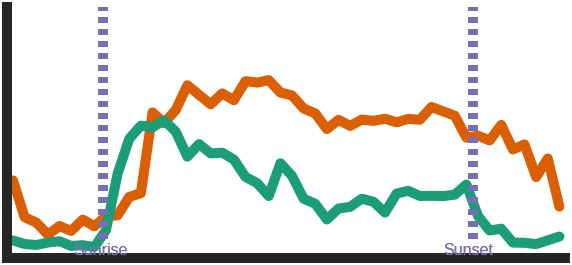

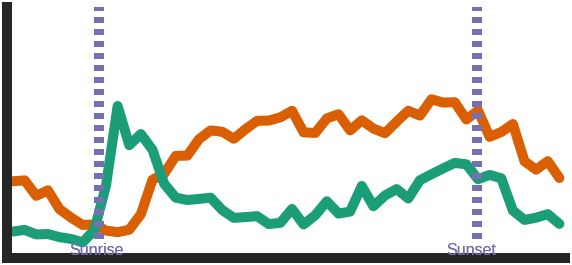

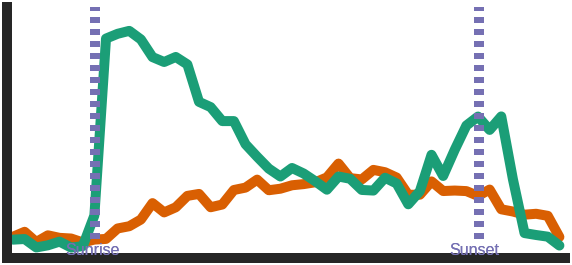

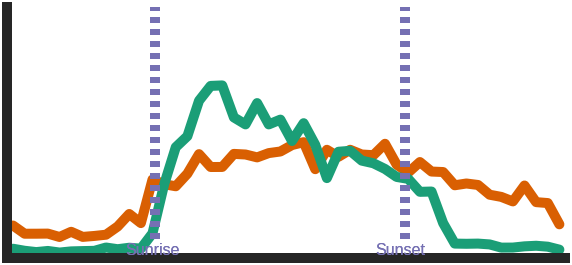

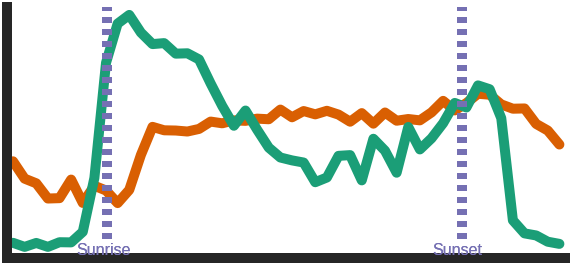

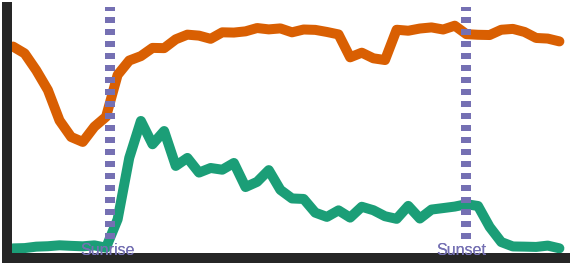

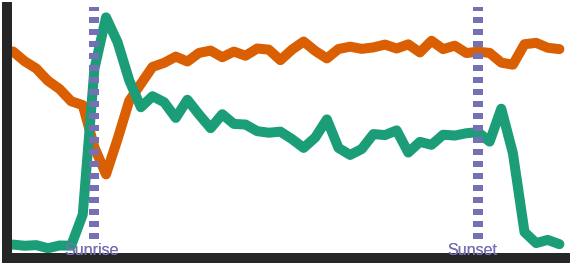

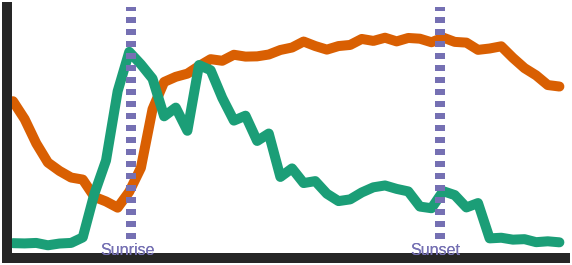

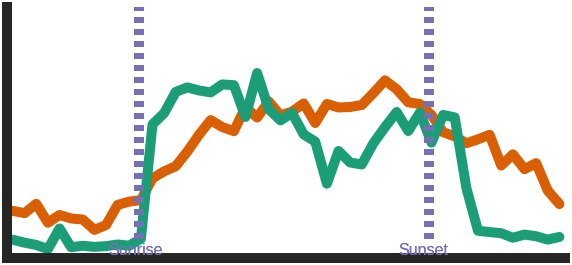

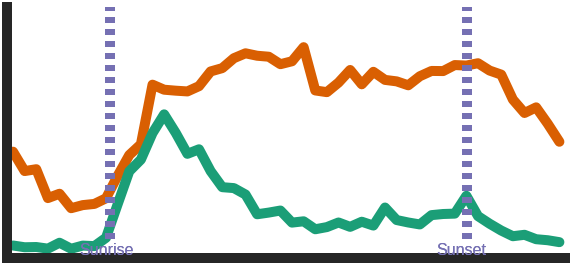

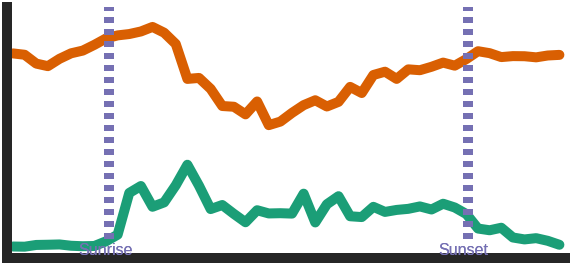

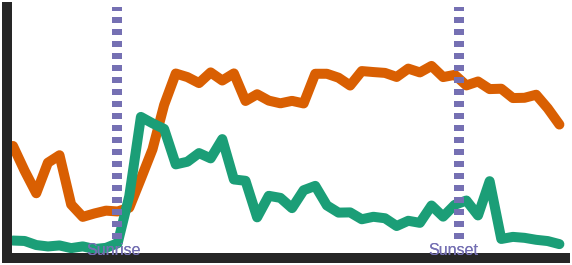

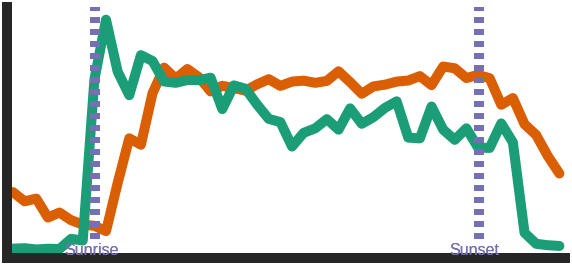

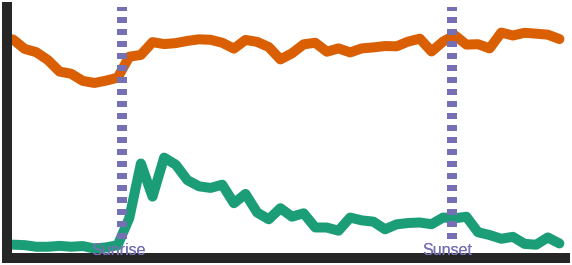

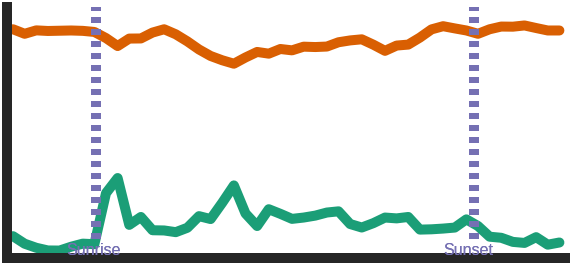

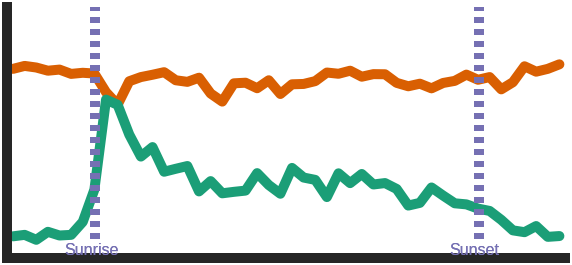

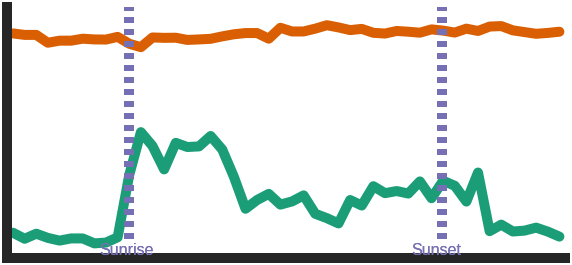

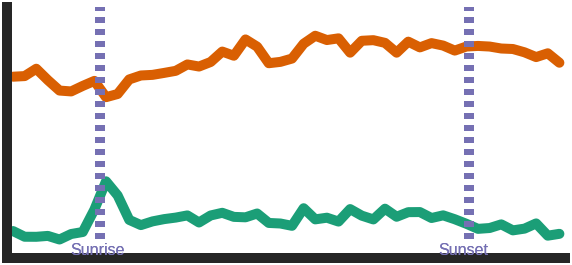

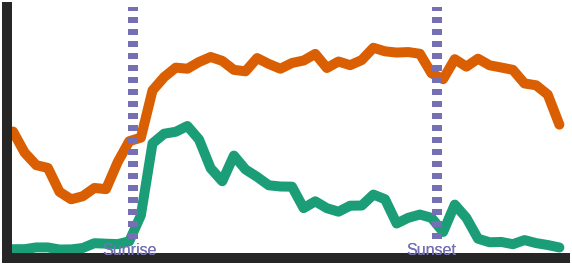

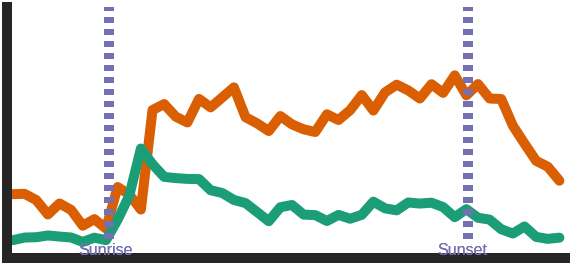

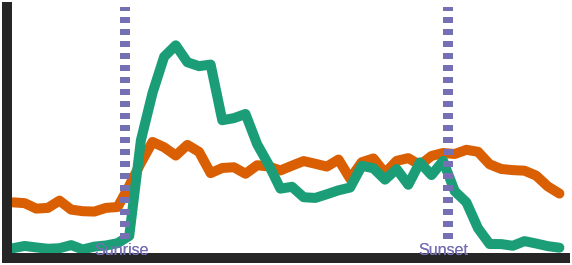

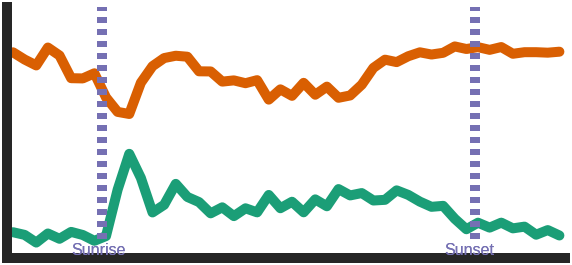

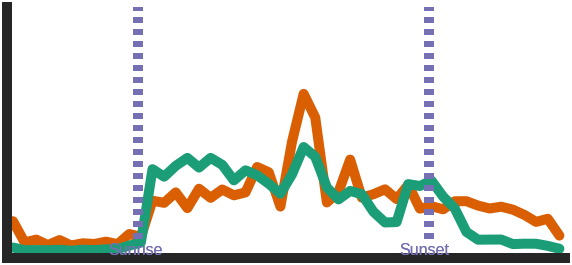

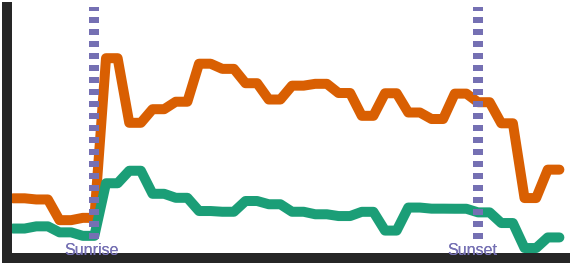

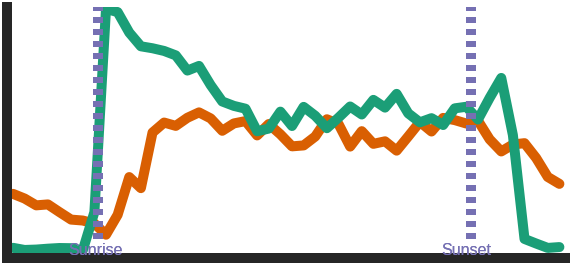

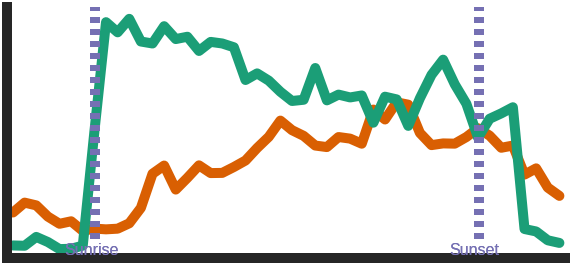

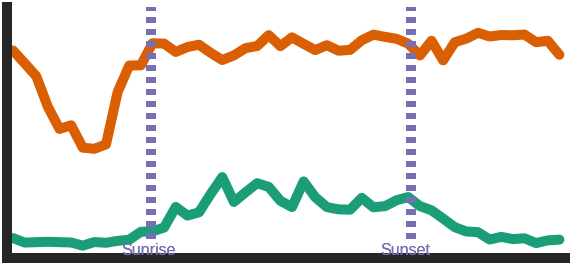

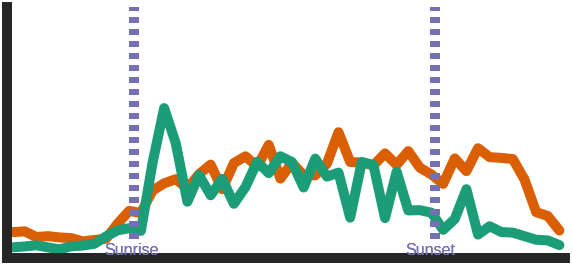

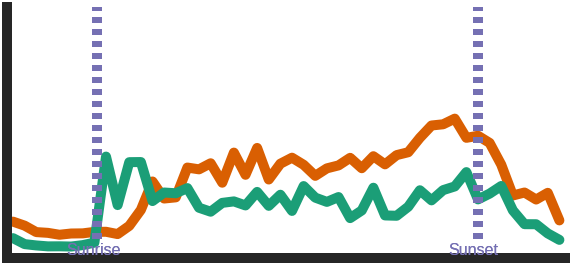

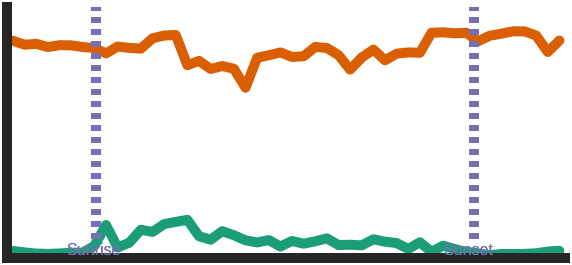

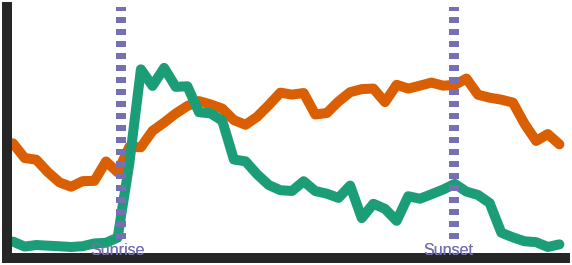

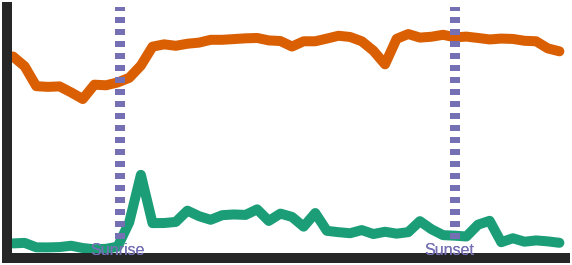

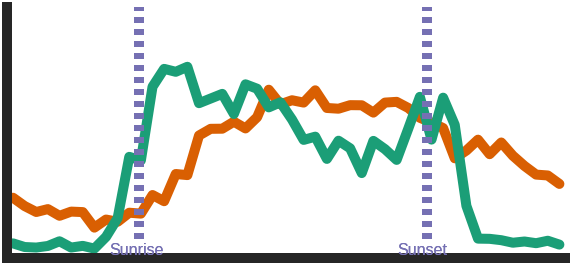

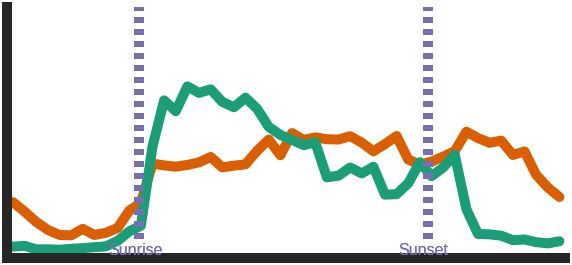

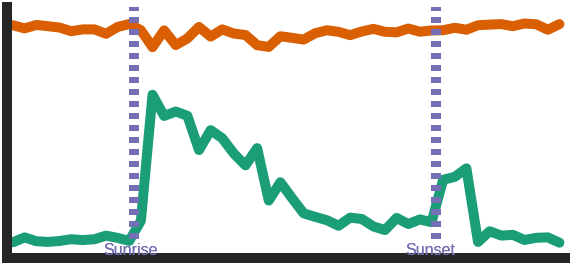

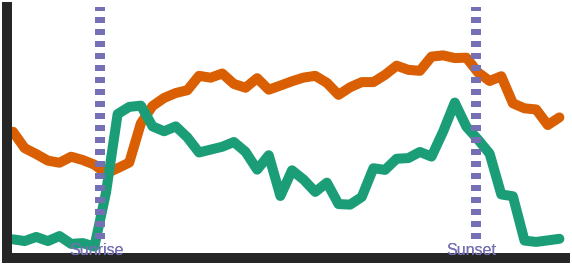

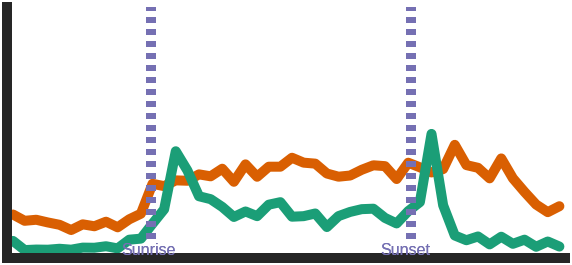

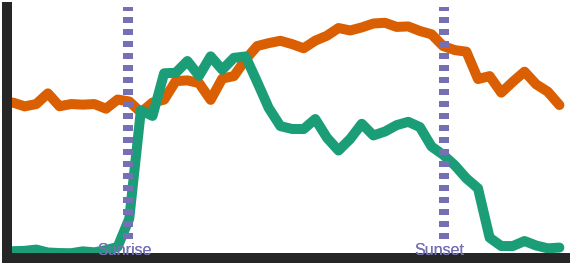

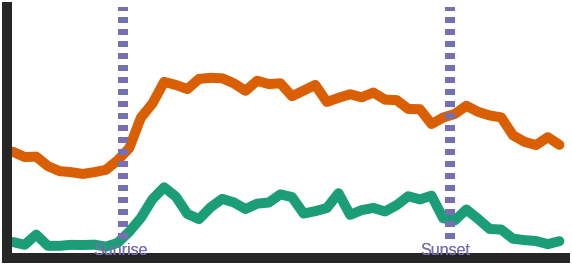

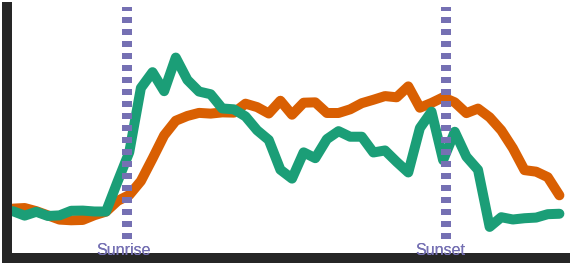

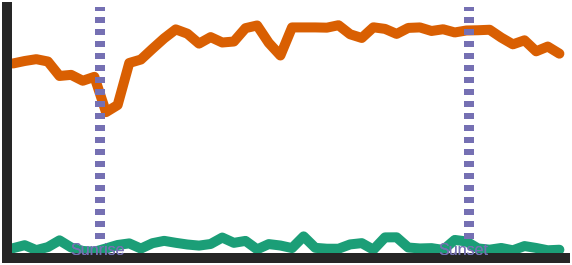

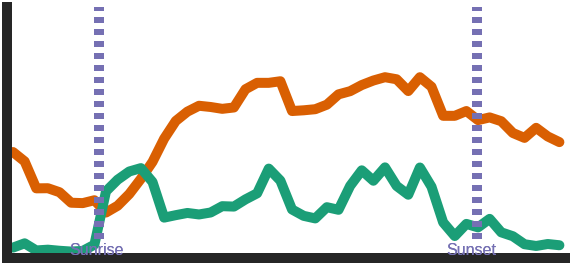

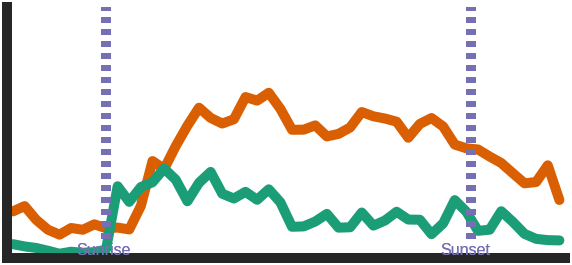

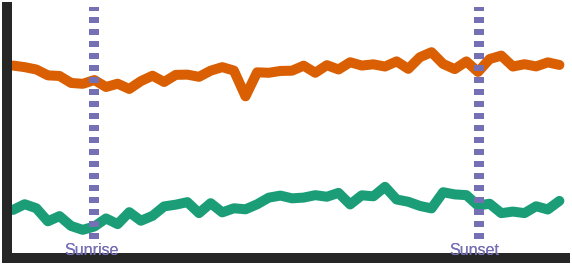

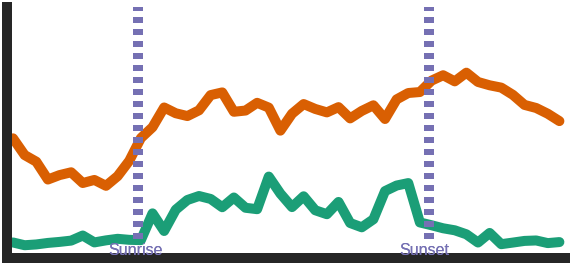

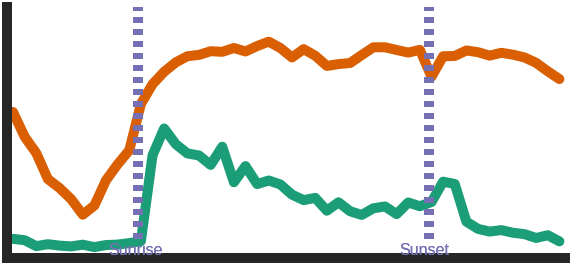

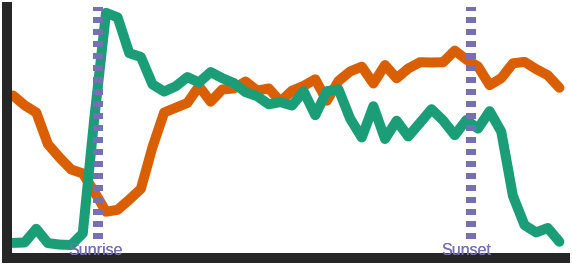

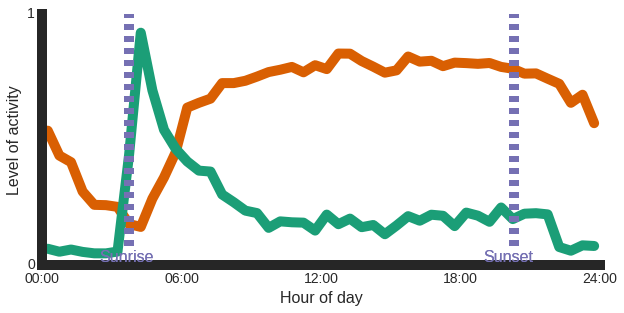

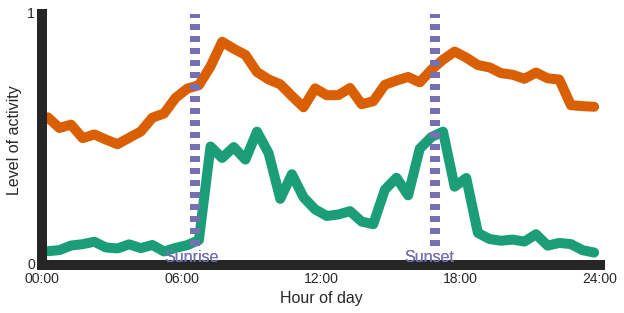

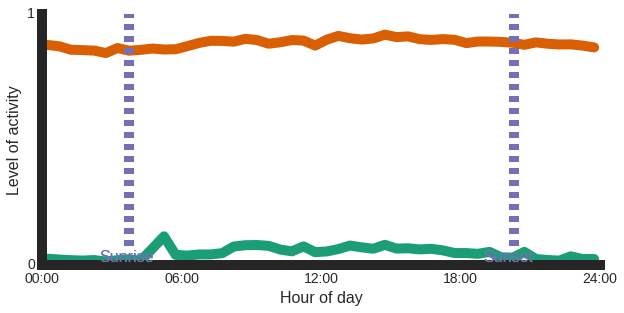

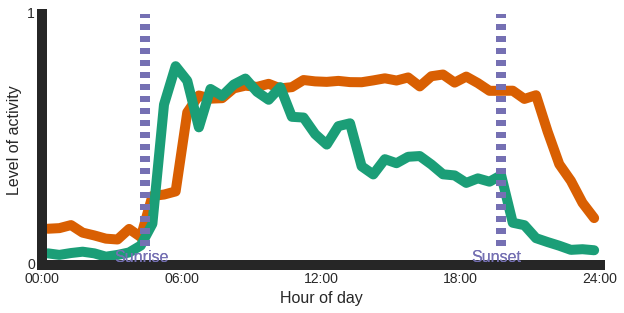

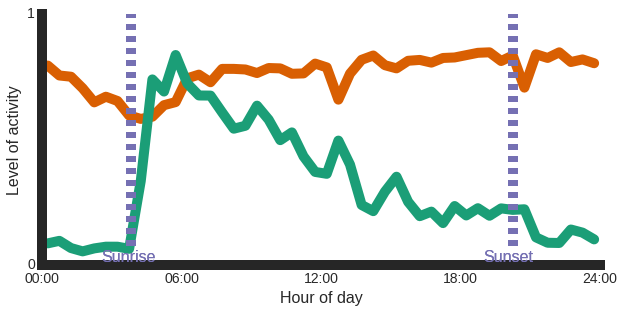

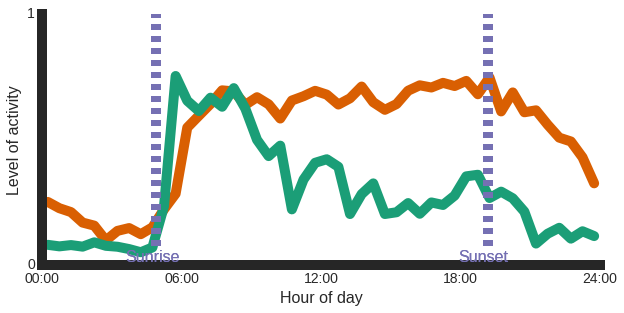

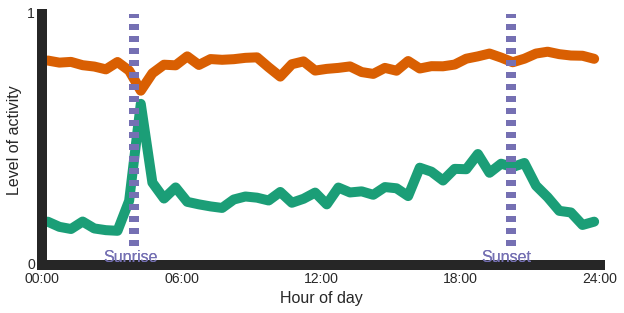

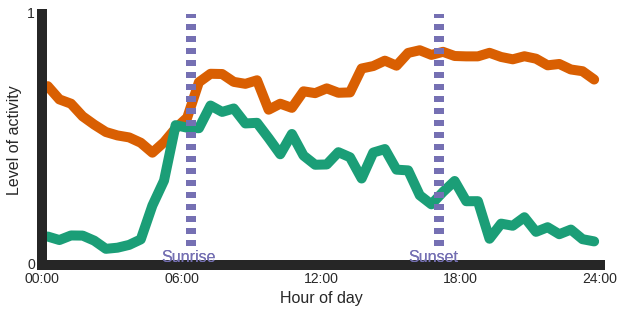

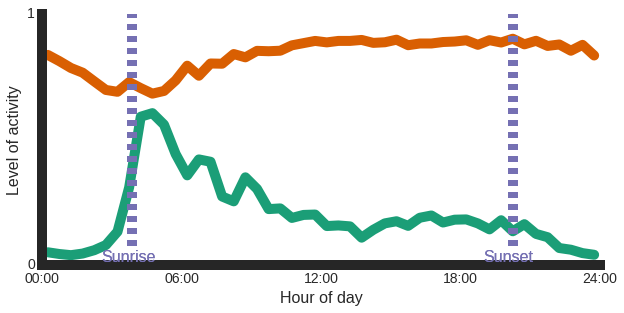

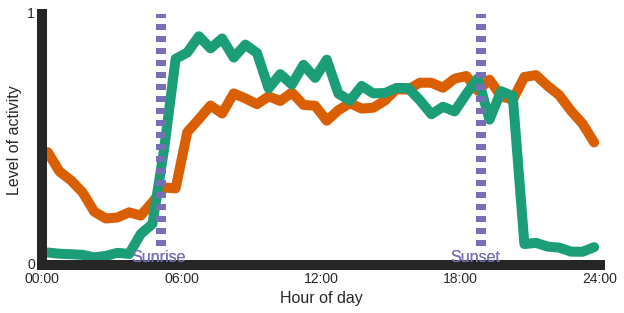

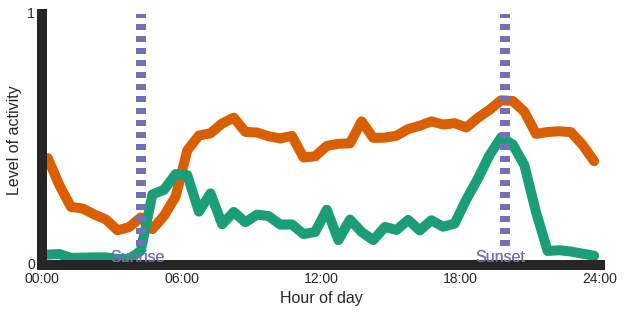

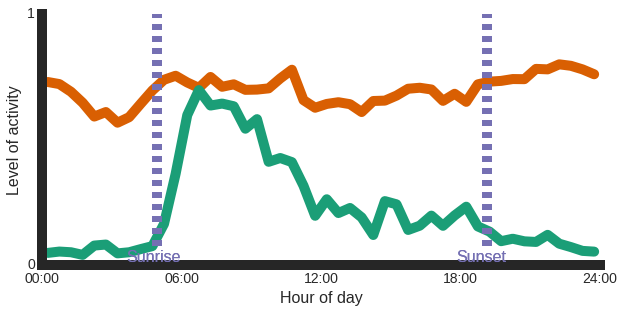

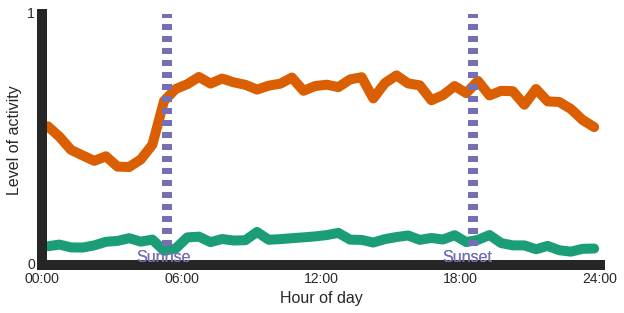

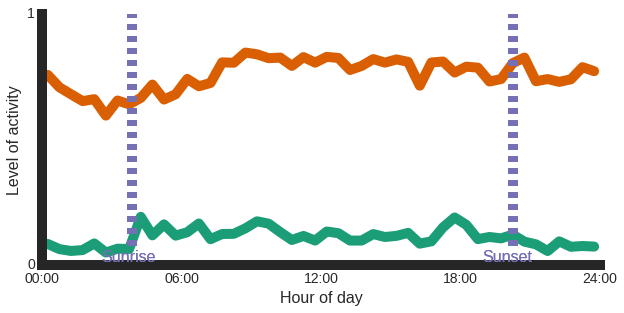

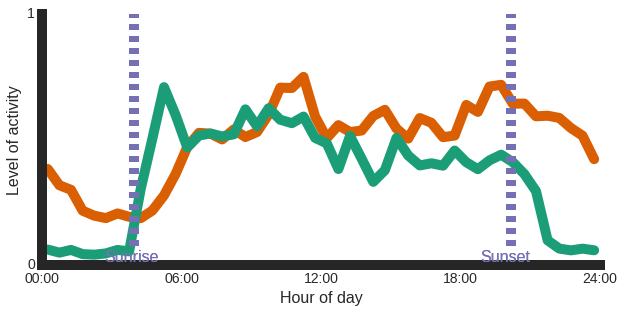

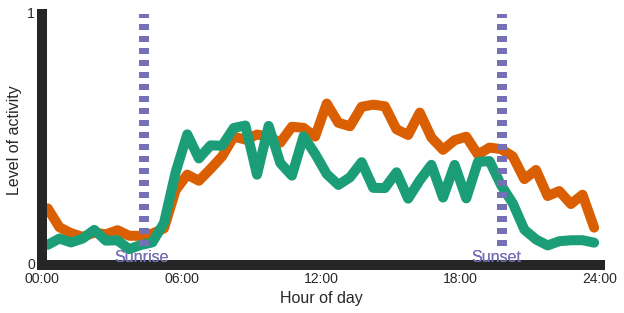

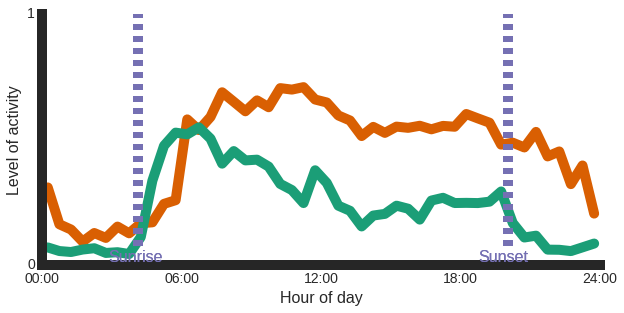

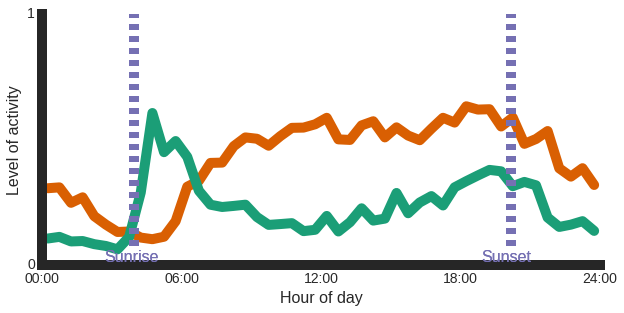

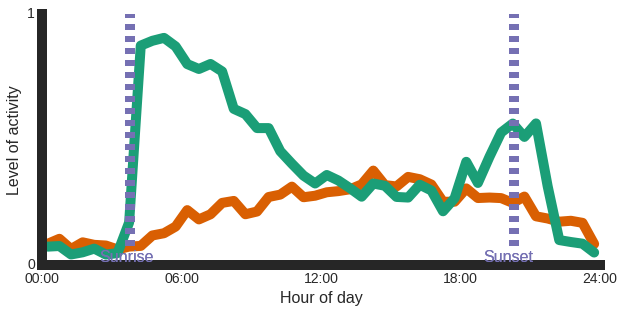

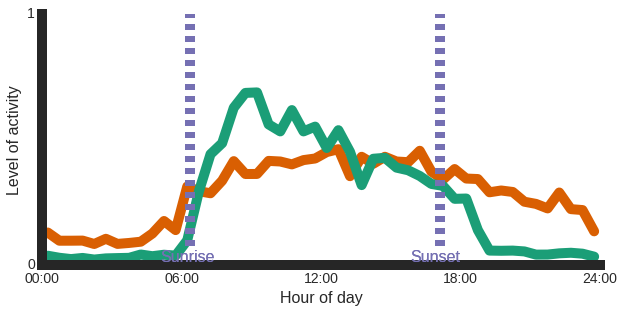

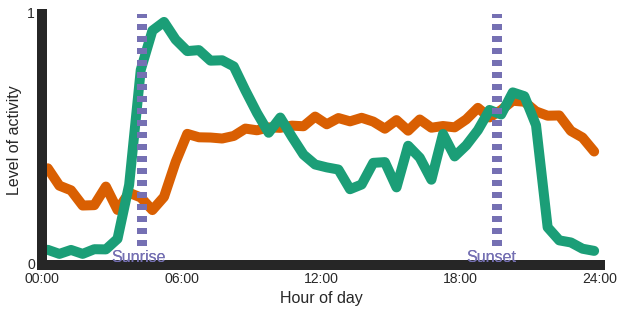

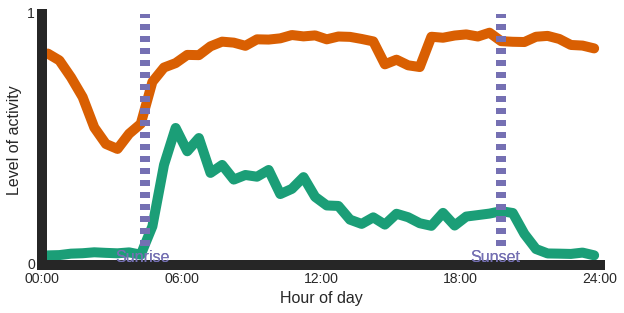

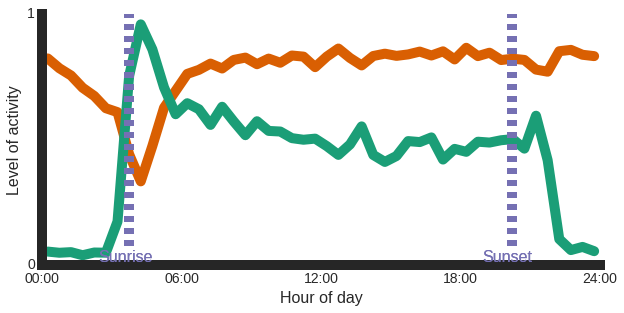

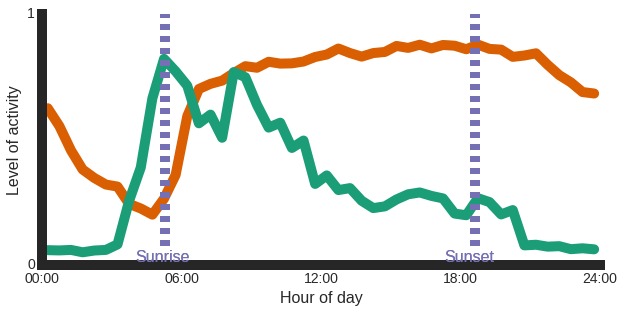

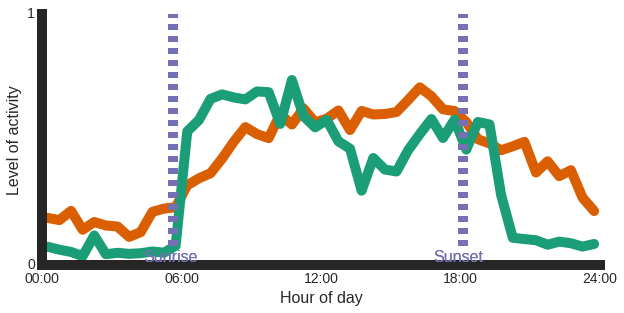

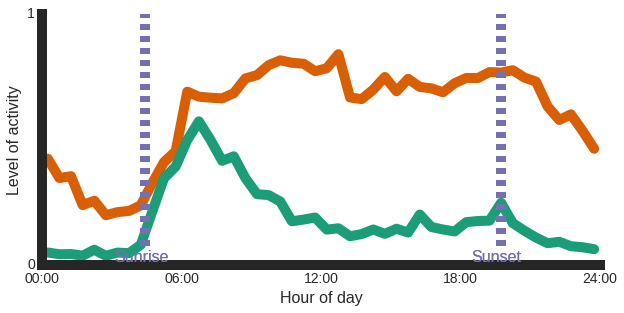

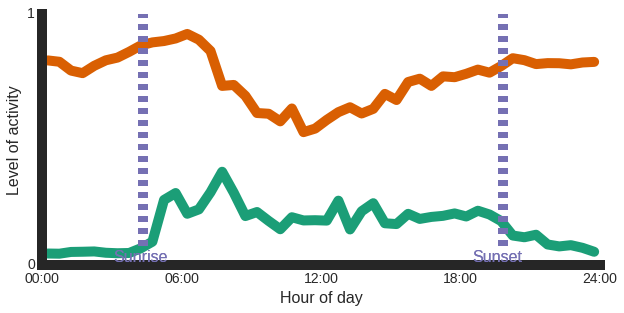

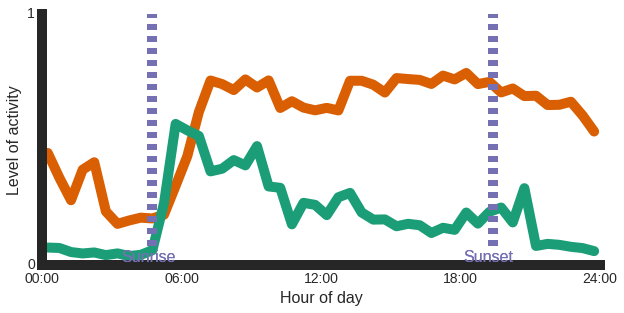

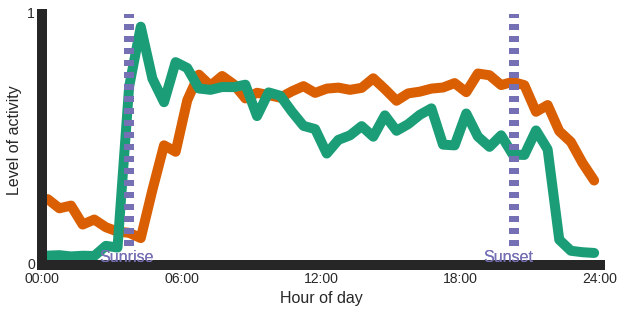

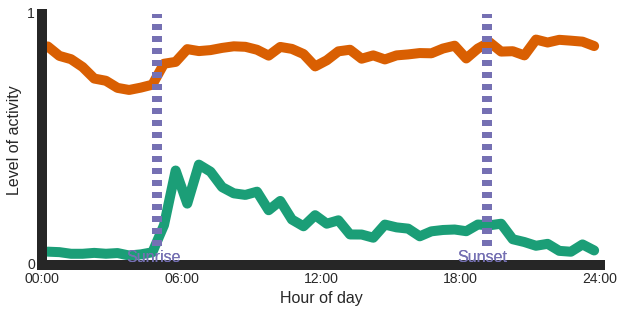

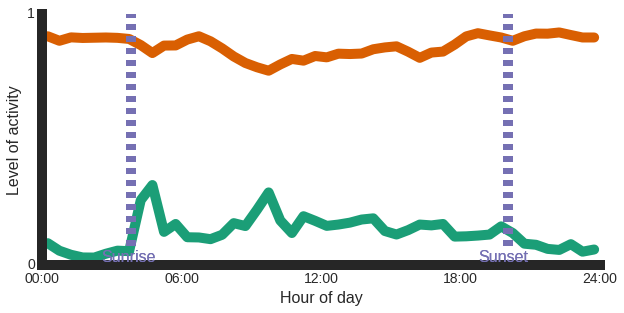

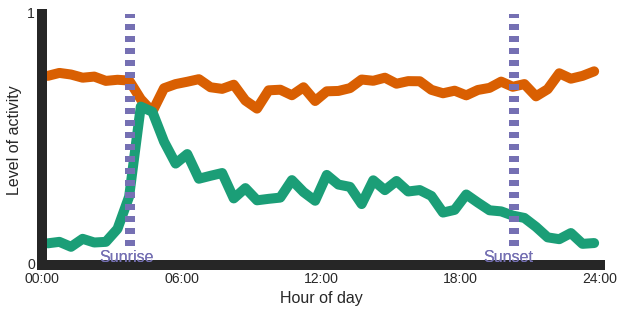

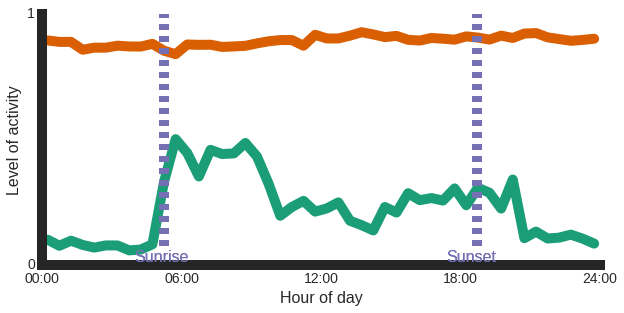

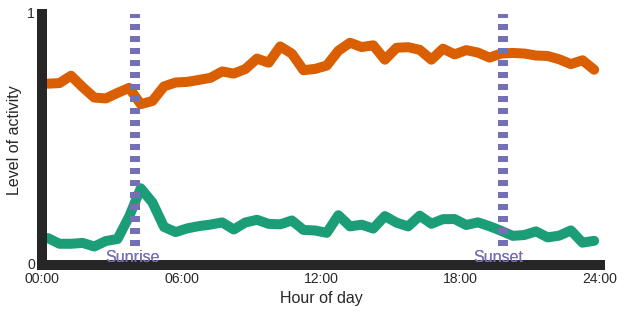

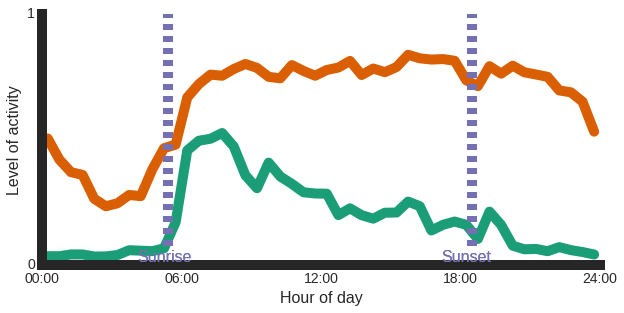

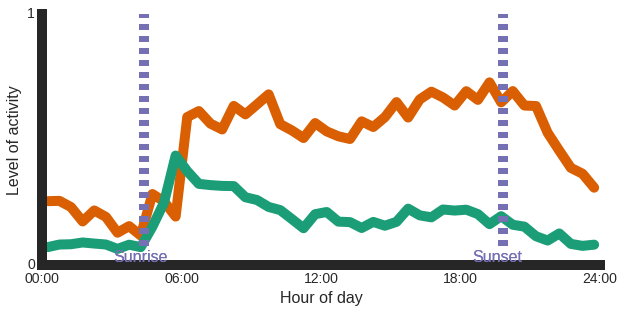

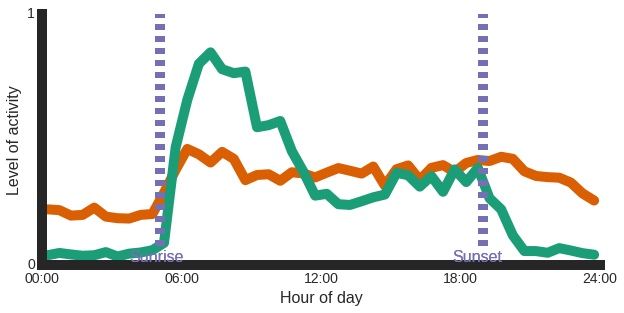

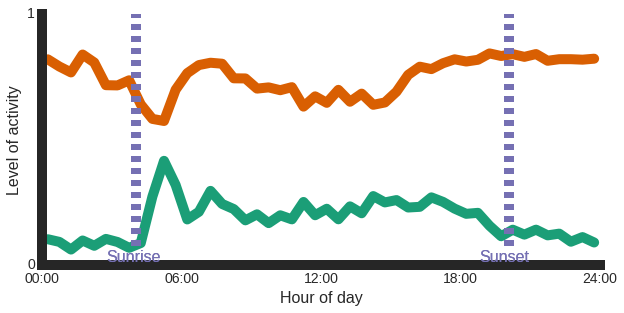

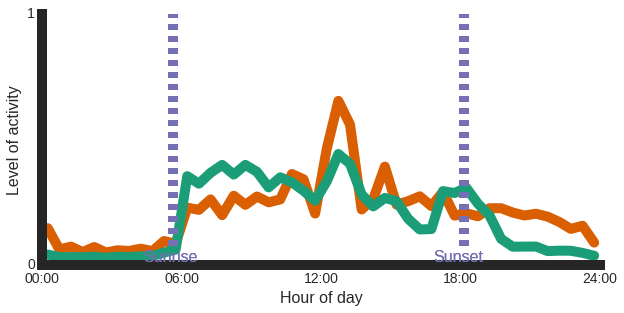

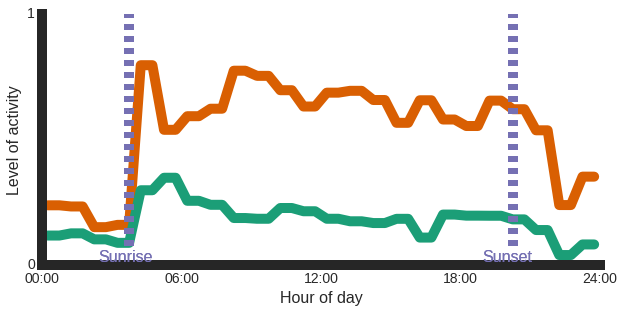

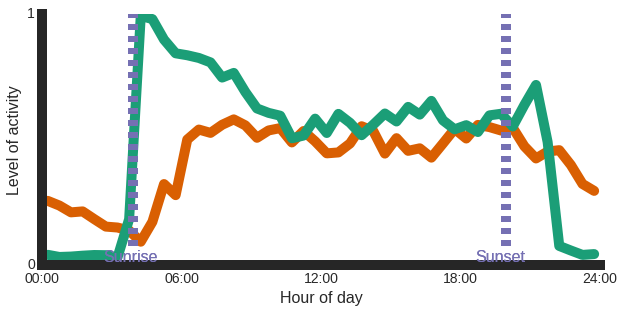

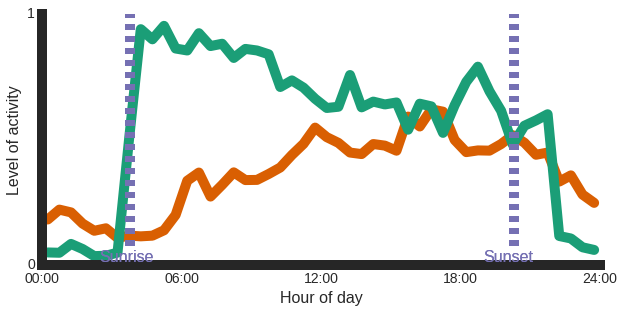

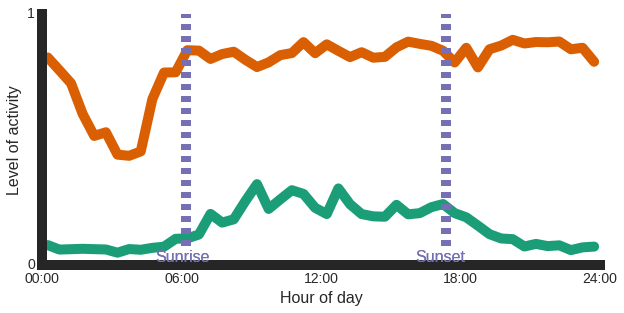

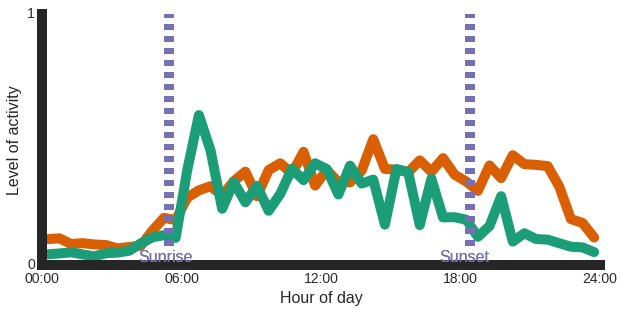

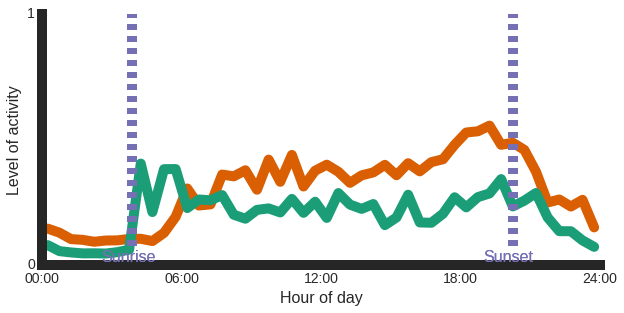

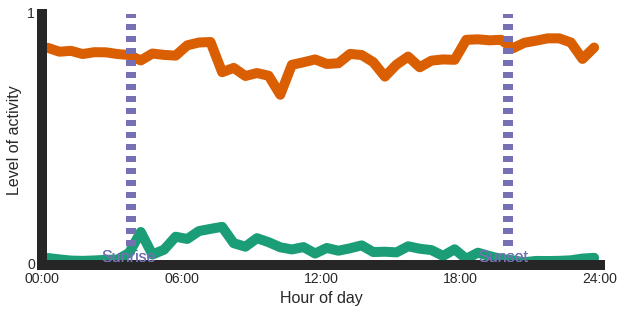

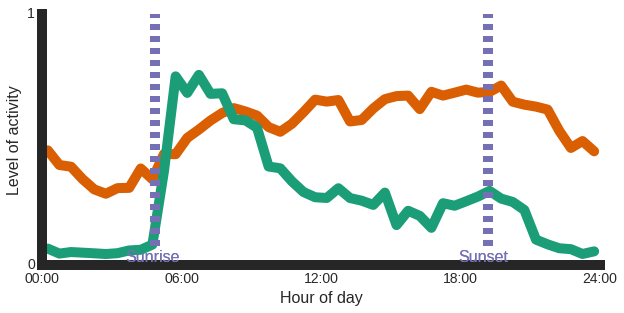

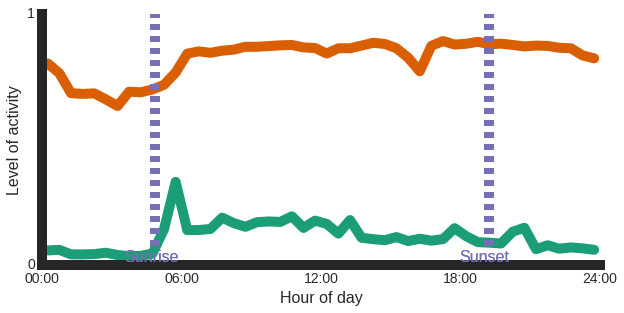

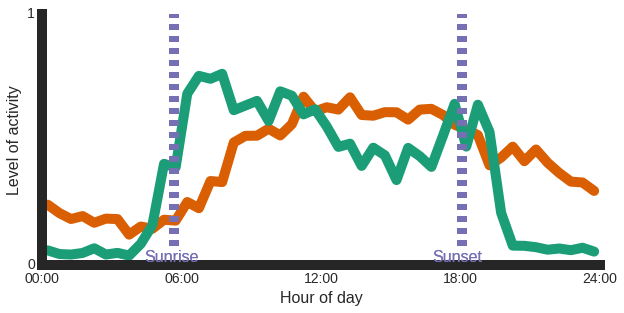

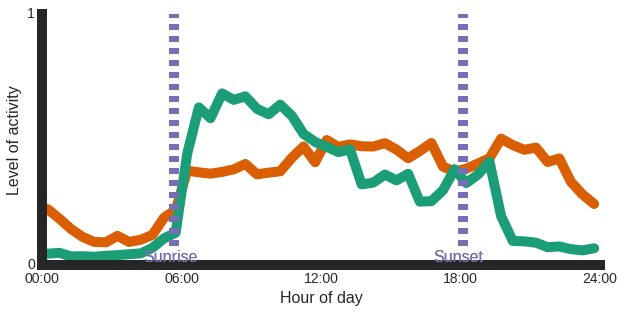

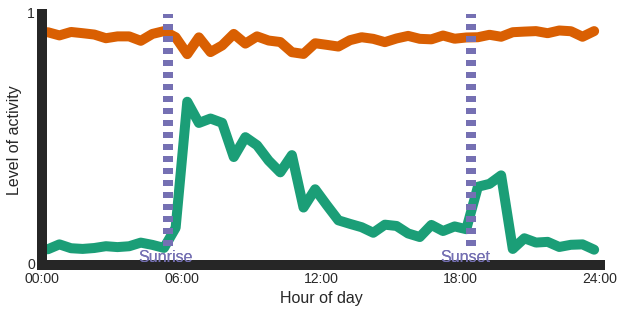

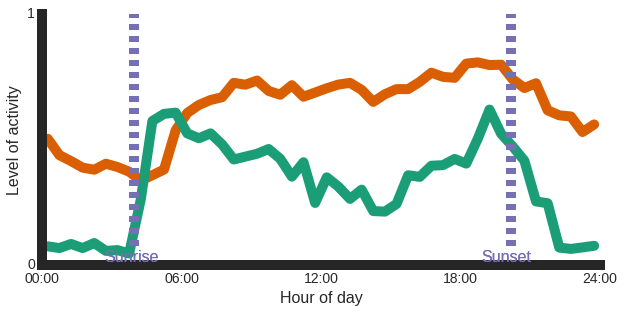

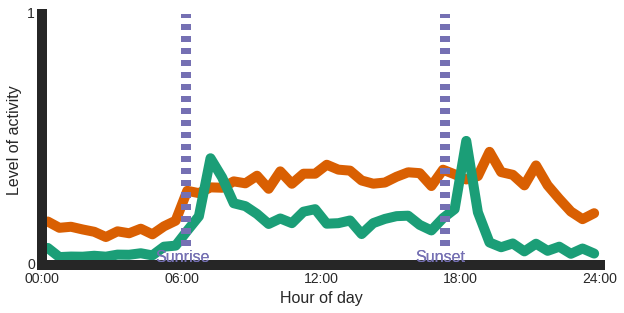

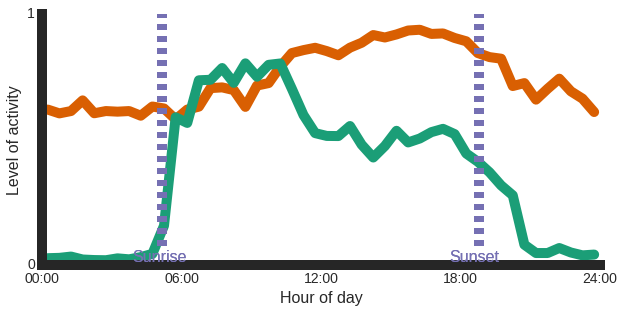

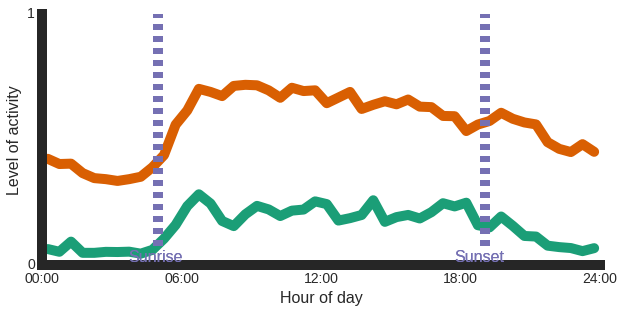

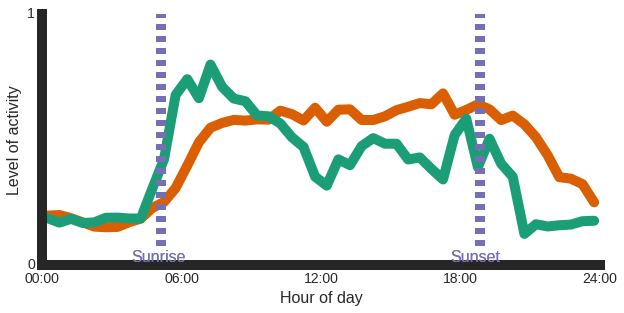

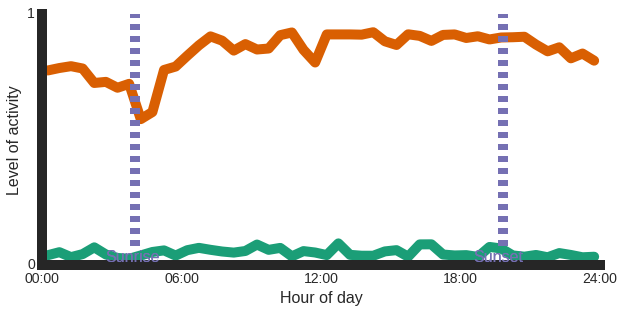

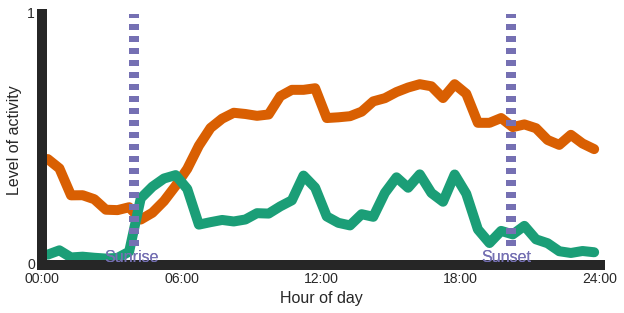

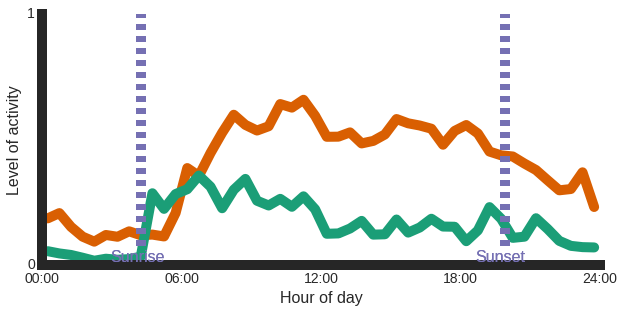

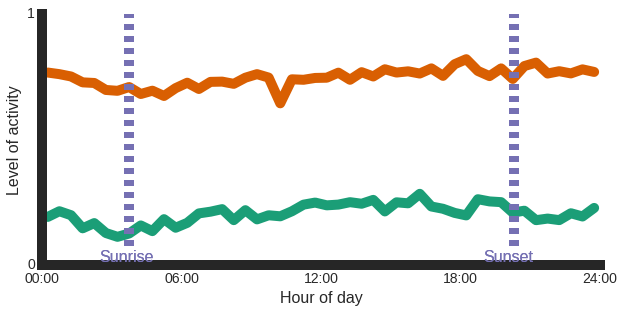

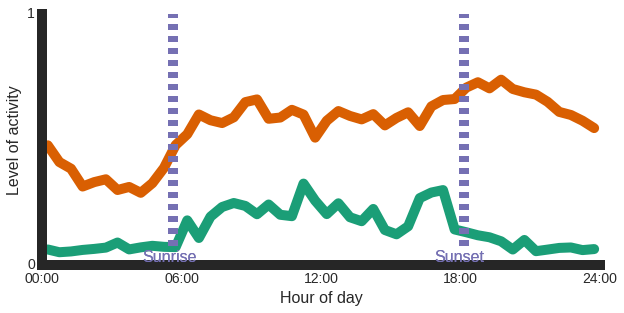

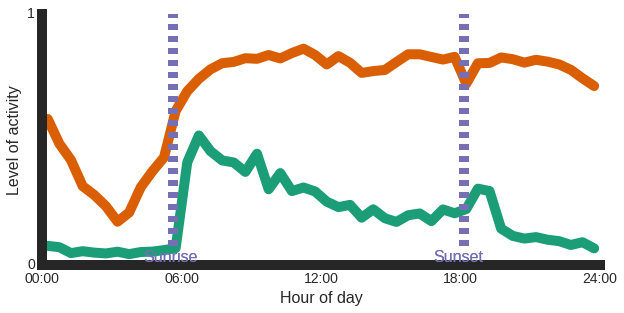

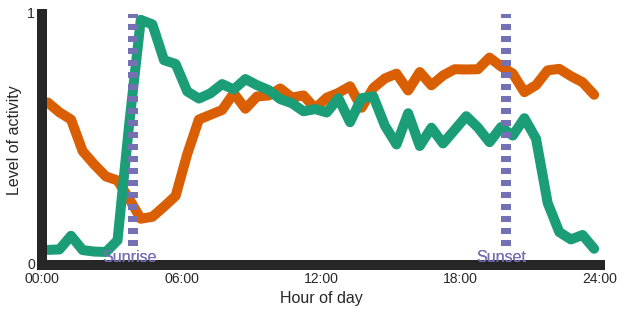

In [53]:
savedir = '/home/michael/Dropbox/engage/FairbrassFirmanetal_/data/predictions/massive_dataset/graphs/'

for style_level in [0, 1, 2]:
    
    if not os.path.exists(savedir + str(style_level)):
        os.makedirs(savedir + str(style_level))
        
    for sitename in site_filtered['biotic']:
        plot_site(sitename, style_level=style_level)
        plt.savefig(savedir + '/' + str(style_level) + '/' + sitename + '.png', dpi=60,
                   bbox_inches='tight')        
        plt.savefig(savedir + '/' + str(style_level) + '/' + sitename + '.pdf', dpi=60,
                   bbox_inches='tight')        

# Saving to json

In [59]:
import json

mapper = {'anthrop': 'Anthropogenic', 'biotic': 'Biotic'}

def time_to_str(time):
    rounded = time - 0.25
    if round(rounded) != rounded:
        return "%02d:30" % rounded
    else:
        return "%02d:00" % rounded

In [60]:
savedir = '../../website/mapapp/assets/sites/chartdata/'

for sitename in site_filtered['biotic']:
    tosave = []
    for classname in classnames:
        times, averages = get_times_and_averages(sitename, classname)
        data = [[time_to_str(time), str(avg)] for time, avg in zip(times, averages)]
        tosave.append({'name': mapper[classname], 'data': data})

    json.dump(tosave, open(savedir + sitename.replace('_', '') + '.json', 'w'))